<h1 style="text-align:center;">  MACHINE LEARNING PREDICTOR MODEL FOR SPANISH LEAGUE FIRST DIVISION</h1>


<img src="./img/portada.jpg" alt="Logo" style="display: block; margin: auto;" width="600" />


# Notebook Index

- [1. Imports](#Imports)
- [2. Subjects](#SUBJECT)
- [3. Data Extraction](#DATA-EXTRACTION)
- [4. Dataset](#Dataset)
- [5. Rolling Average Dataset](#RAD)
- [6. TRAIN AND TEST](#traintest)
- [7. Mini EDA](#EDA)
- [8. First Model](#firstmodel)
- [9. Adding new features](#addfeature)
- [10. Multiple model training](#multimodel)
- [11. One-hot encoding](#onehot)
- [12. Checking feature importance](#featureimportance)
- [13. Imbalanced classes](#imbalanced)
- [14. Predictions](#predictions)
- [15. Conclusions](#conclusions)


## 1. IMPORTS <a id="Imports"></a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, make_scorer, f1_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

In [2]:
warnings.filterwarnings('ignore')

In [3]:
import multiprocessing
multiprocessing.cpu_count()

12

## 2. SUBJECT <a id="SUBJECT"></a>

In this ML project, we are going to create a model that, trained with statistical data from the league's teams, aims to predict outcomes of Spanish First Division football matches using machine learning classification algorithms.

## 3. DATA EXTRACTION <a id="DATA-EXTRACTION"></a>

### DATASETS AND SOURCES

In [4]:
df = pd.read_csv("clean_data_final.csv")
source = "https://fbref.com/en/"


## 4. Dataset <a id="Dataset"></a>

In [5]:
df.head()

,Unnamed: 0,date,time,round,day,home_team,away_team,goals_home,goals_away,xg_home,...,season,target,poss_away,formation_away,sh_away,sot_away,dist_away,fk_away,pk_away,pkatt_away
0,0,2023-09-02,16:15,4,5,19,3,2.0,1.0,2.8,...,2024,0,24.0,4-1-3-2,6.0,2.0,19.9,0.0,0,0
1,1,2023-09-17,21:00,5,6,19,4,2.0,1.0,2.0,...,2024,0,48.0,4-3-3,15.0,5.0,17.6,0.0,0,0
2,2,2023-09-27,19:00,7,2,19,6,2.0,0.0,1.7,...,2024,0,52.0,4-5-1,16.0,2.0,21.5,1.0,0,0
3,3,2023-10-07,16:15,9,5,19,8,4.0,0.0,3.2,...,2024,0,33.0,4-3-3,7.0,1.0,24.4,0.0,0,0
4,4,2023-11-05,21:00,12,6,19,11,0.0,0.0,2.2,...,2024,2,37.0,4-1-4-1,4.0,0.0,23.3,0.0,0,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2580 entries, 0 to 2579
Data columns (total 30 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      2580 non-null   int64  
 1   date            2580 non-null   object 
 2   time            2580 non-null   object 
 3   round           2580 non-null   int64  
 4   day             2580 non-null   int64  
 5   home_team       2580 non-null   int64  
 6   away_team       2580 non-null   int64  
 7   goals_home      2580 non-null   float64
 8   goals_away      2580 non-null   float64
 9   xg_home         2580 non-null   float64
 10  xg_away         2580 non-null   float64
 11  poss_home       2580 non-null   float64
 12  formation_home  2580 non-null   object 
 13  referee         2580 non-null   object 
 14  sh_home         2580 non-null   float64
 15  sot_home        2580 non-null   float64
 16  dist_home       2580 non-null   float64
 17  fk_home         2580 non-null   f

**Dataset: df**

**Description: This dataset consists of the statistics of each match played  that we have considered "important" for making predictions.**

**Period: Last 7 seasons of La Liga, from 17/18 to the current 23/24 up to matchday 29 (we will use the 10 matches of matchday 30 for the prediction)**

|Column|Description|Type_of_variable|initial_importance|Notes|
|:-:|:-:|:-:|:-:|-|
| date           | Date the match was played                                      | date            | 1 |
| time           | The time when the match was played                             | date            | 1 |
| round          | The matchday of the game being played                          | discrete numeric| 2 |
| day            | Day of the week when the match is played                       | discrete numeric| 1 | This column has been preprocessed to be numeric, starting on 0 for Monday up to 6 for Sunday
| home_team      | The team playing as the home club                               | discrete numeric| 0 | This column has been preprocessed to be numeric, a dictionary will be added below to identify each team by its designated number.
| away_team      | Team playing visiting the home club                             | discrete numeric| 0 | This column has been preprocessed to be numeric, a dictionary will be added below to identify each team by its designated number.
| goals_home     | Goals scored by the home team                                   | discrete numeric| 1 |
| goals_away     | Goals scored by the away team                                   | discrete numeric| 1 |
| xg_home        | The expected goals created by the home team                     | continuous numeric| 1 |
| xg_away        | The expected goals created by the away team                     | continuous numeric| 1 |
| poss_home      | Posession of the home team.                                     | discrete numeric     | 1 |
| formation_home | Formation of the home team.                                     | Categorical     | 2 |
| referee        | Referee of the match.                                           | Categorical     | 2 |
| sh_home        | Shots by the home team.                                         | discrete numeric     | 1 | Does not include penalty kicks
| sot_home       | Shots on target by the home team.                               | discrete numeric    | 1 | Does not include penalty kicks
| dist_home      | Average shot distance for home team, Average distance, in yards, from goal of all shots taken | continuous numeric    | 2 | Does not include penalty kicks
| fk_home        | Shots from free kicks.                                          | discrete numeric    | 2 |
| pk_home        | Penalty kicks converted by the home team.                         | discrete numeric     | 1 |
| pkatt_home     | Penalty kick attempts by the home team.                         | discrete numeric    | 1 |
| season         | Season of the match.                                            | discrete numeric     | 1 |
| target         | Target variable indicating the outcome of the match.            | discrete numeric     | 0 | 0 is home victory, 1 is away victory, 2 is draw
| poss_away      | Posession of the away team.                                     | discrete numeric    | 1 |
| formation_away | Formation of the away team.                                     | Categorical     | 2 |
| sh_away        | Shots by the away team.                                         | discrete numeric     | 1 | Does not include penalty kicks
| sot_away       | Shots on target by the away team.                               | discrete numeric    | 1 | Does not include penalty kicks
| dist_away      | Distance covered by the away team.                              | continuous numeric    | 2 | Does not include penalty kicks
| fk_away        | Free kicks awarded to the away team.                            | discrete numeric     | 2 |
| pk_away        | Penalty kicks converted by the away team.                         | discrete numeric    | 1 |
| pkatt_away     | Penalty kick attempts by the away team.                         | discrete numeric     | 1 |


#### Here is the dictionary containing the keys for every team

In [7]:
dict_teams = {'Athletic Club': 0,
 'Almeria': 1,
 'Celta Vigo': 2,
 'Getafe': 3,
 'Real Sociedad': 4,
 'Atletico Madrid': 5,
 'Las Palmas': 6,
 'Girona': 7,
 'Osasuna': 8,
 'Sevilla': 9,
 'Barcelona': 10,
 'Rayo Vallecano': 11,
 'Valencia': 12,
 'Cadiz': 13,
 'Granada': 14,
 'Real Betis': 15,
 'Villarreal': 16,
 'Alaves': 17,
 'Mallorca': 18,
 'Real Madrid': 19,
 'Valladolid': 20,
 'Elche': 21,
 'Espanyol': 22,
 'Levante': 23,
 'Huesca': 24,
 'Eibar': 25,
 'Leganes': 26,
 'Malaga': 27,
 'Deportivo La Coruna': 28}

### **Final cleanup/treatment of the dataset**

In [8]:
df.set_index('Unnamed: 0', inplace=True)

### Since there are multiple match times accross the 7 seasons, we will transform the time column into a new numeric value from 0-2 to simplify.

In [9]:
df['time'] = pd.to_datetime(df['time']).dt.hour
df['time_group'] = pd.cut(df['time'], bins=[0, 16, 20, 24], labels=[0, 1, 2], right=False)

#### When I reached this point I realized it would be imposible to train the model with these stats since they will only be available post-game. To address this issue, we will apply a rolling average to all statistical columns of the match and train the model with these values. We will load a new dataset that contain all columns previously described plus the new columns with the rolling averages.

### 5. ROLLING AVERAGE DATASET <a id="RAD"></a>

In [10]:
df_rolling = pd.read_csv("rolling_avg_final.csv")
df_rolling.set_index('Unnamed: 0', inplace=True)
df_rolling.index.name = None

In [11]:
df_rolling.head()

,date,time,round,day,home_team,away_team,goals_home,goals_away,xg_home,xg_away,...,goals_home_rolling,goals_away_rolling,pkatt_home_rolling,poss_away_rolling,sh_away_rolling,sot_away_rolling,dist_away_rolling,fk_away_rolling,pk_away_rolling,pkatt_away_rolling
0,2023-09-02,16,4,5,19,3,2.0,1.0,2.8,0.4,...,2.000000,0.333333,0.333333,36.666667,9.333333,2.333333,15.633333,0.333333,0.333333,0.333333
1,2023-09-17,21,5,6,19,4,2.0,1.0,2.0,1.6,...,2.000000,2.000000,0.333333,54.000000,11.333333,3.000000,16.866667,0.333333,0.000000,0.000000
2,2023-09-27,19,7,2,19,6,2.0,0.0,1.7,0.7,...,1.666667,0.333333,0.000000,55.666667,11.333333,3.333333,21.100000,0.666667,0.000000,0.000000
3,2023-10-07,16,9,5,19,8,4.0,0.0,3.2,0.5,...,2.000000,0.666667,0.000000,51.000000,13.000000,2.333333,17.700000,0.666667,0.000000,0.000000
4,2023-11-05,21,12,6,19,11,0.0,0.0,2.2,0.1,...,2.333333,1.666667,0.333333,43.666667,11.333333,4.666667,22.900000,2.000000,0.333333,0.333333


In [12]:
df_rolling.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2580 entries, 0 to 2579
Data columns (total 48 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   date                2580 non-null   object 
 1   time                2580 non-null   int64  
 2   round               2580 non-null   int64  
 3   day                 2580 non-null   int64  
 4   home_team           2580 non-null   int64  
 5   away_team           2580 non-null   int64  
 6   goals_home          2580 non-null   float64
 7   goals_away          2580 non-null   float64
 8   xg_home             2580 non-null   float64
 9   xg_away             2580 non-null   float64
 10  poss_home           2580 non-null   float64
 11  formation_home      2580 non-null   object 
 12  referee             2580 non-null   object 
 13  sh_home             2580 non-null   float64
 14  sot_home            2580 non-null   float64
 15  dist_home           2580 non-null   float64
 16  fk_home    

#### We are using a window of 3 for rolling averages, which means we will take into account the last 3 games a team has played to calculate the rolling average. This is regardless of the team played home or away.

In [13]:
prediction_sample = df_rolling[(df_rolling["round"] == 30) & (df_rolling["season"] == 2024)]
#we extract the last matchday available so we can use it for prediction.

In [14]:
df_rolling.drop(df_rolling[(df_rolling["round"] == 30) & (df_rolling["season"] == 2024)].index, inplace=True)
#excluding prediction data from our dataframe.

In [15]:
prediction_sample.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10 entries, 14 to 299
Data columns (total 48 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   date                10 non-null     object 
 1   time                10 non-null     int64  
 2   round               10 non-null     int64  
 3   day                 10 non-null     int64  
 4   home_team           10 non-null     int64  
 5   away_team           10 non-null     int64  
 6   goals_home          10 non-null     float64
 7   goals_away          10 non-null     float64
 8   xg_home             10 non-null     float64
 9   xg_away             10 non-null     float64
 10  poss_home           10 non-null     float64
 11  formation_home      10 non-null     object 
 12  referee             10 non-null     object 
 13  sh_home             10 non-null     float64
 14  sot_home            10 non-null     float64
 15  dist_home           10 non-null     float64
 16  fk_home      

### We extracted the data we will be using in our prediction and stored it "prediction_sample". Furthermore, we dropped these columns from our dataset so we dont train our model with this data.

### 6. **TRAIN AND TEST**<a id="traintest"></a>

## We will now select our features and divide the data in train and test

In [16]:
features = ["round", "day", "away_team", "home_team", "time_group", 'xg_home_rolling', 'xg_away_rolling', 'poss_home_rolling', 'sh_home_rolling',
 'sot_home_rolling', 'dist_home_rolling', 'fk_home_rolling', 'pk_home_rolling', 'goals_home_rolling', 'goals_away_rolling', 'pkatt_home_rolling',
 'poss_away_rolling', 'sh_away_rolling', 'sot_away_rolling', 'dist_away_rolling', 'fk_away_rolling', 'pk_away_rolling', 'pkatt_away_rolling']
#there are 3 features being leftout for the time being, formation_home, formation_away and referee. These are categorical features and we will include them 
#afterwards depending on our first baseline.

In [17]:
X = df_rolling[features]
y = df_rolling['target']

In [18]:
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=42)

### 7. Mini EDA <a id="EDA"></a>

### The features we have selected will be used for our initial model to create a baseline from which we will part. We will now proceed to check our dataframe, target and analyze the features.

In [19]:
df_rolling.target.value_counts(normalize=True) *100

target
0    44.941634
1    27.976654
2    27.081712
Name: proportion, dtype: float64

In [20]:
class_counts = y.value_counts()
class_ratios = class_counts / class_counts.sum()
class_labels = {0: "Home Victory", 1: "Away Victory", 2: "Draw"}

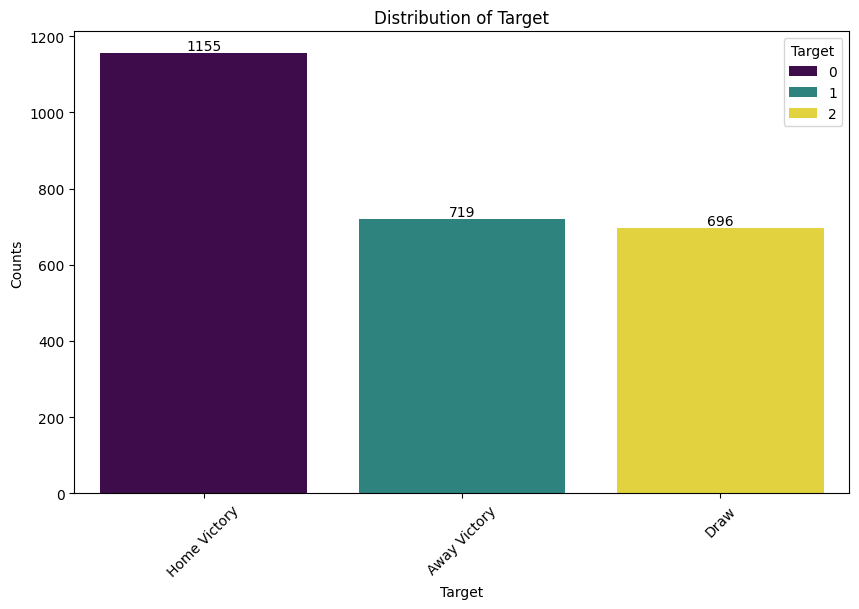

In [21]:
plt.figure(figsize=(10, 6))
sns.barplot(x=class_counts.index.map(class_labels), y=class_counts.values, palette='viridis', hue=class_counts.index)
plt.title('Distribution of Target')
plt.xlabel('Target')
plt.ylabel('Counts')
plt.xticks(rotation=45)


for i, v in enumerate(class_counts.values):
    plt.text(i, v + 0.1, str(v), ha='center', va='bottom')

plt.legend(title='Target')
plt.show()

### It seems our target is somewhat unbalanced between home victory and the other two classes. At first glance it seems there is an inherent advantage for playing at home.

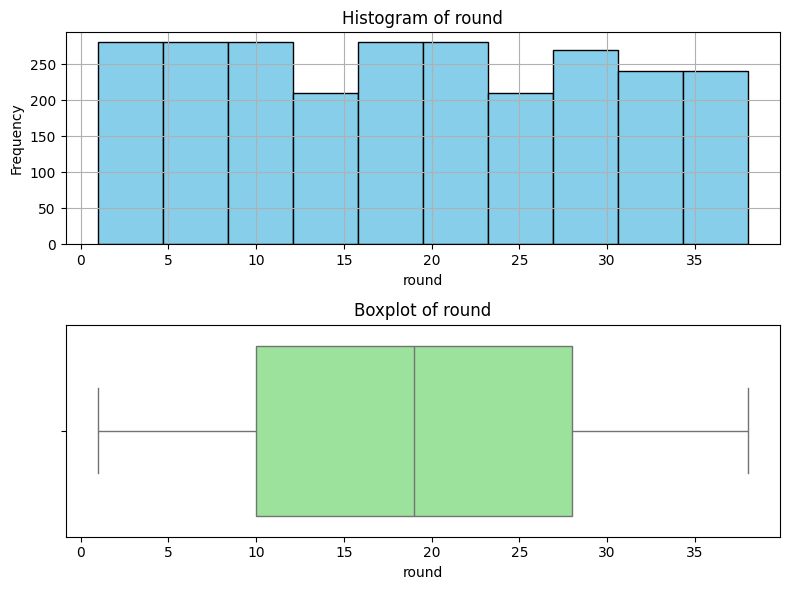

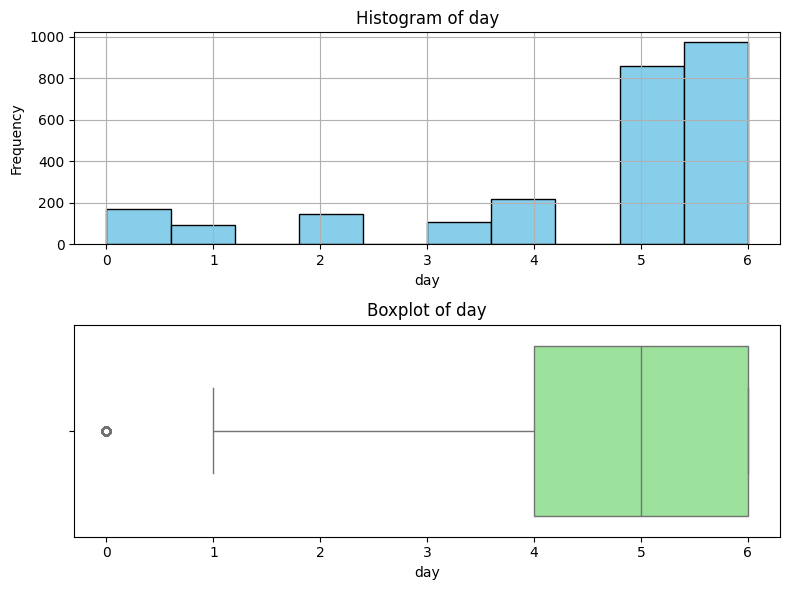

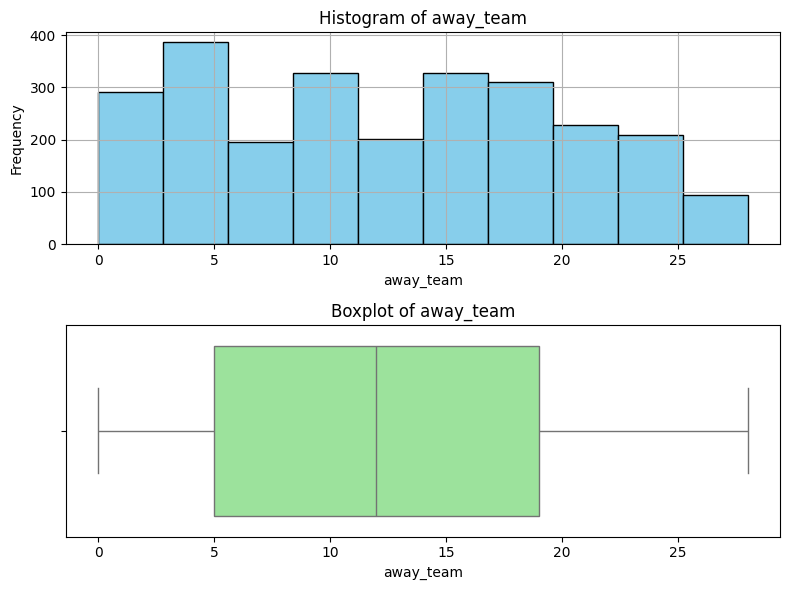

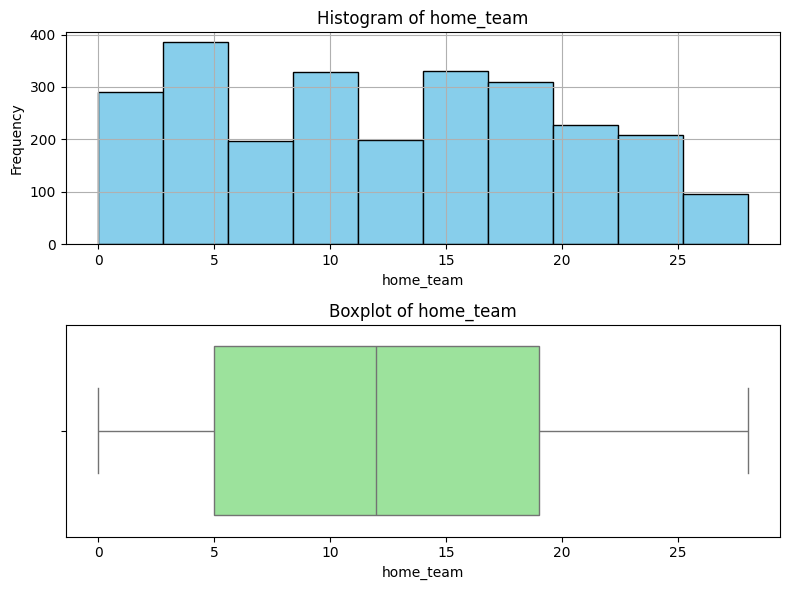

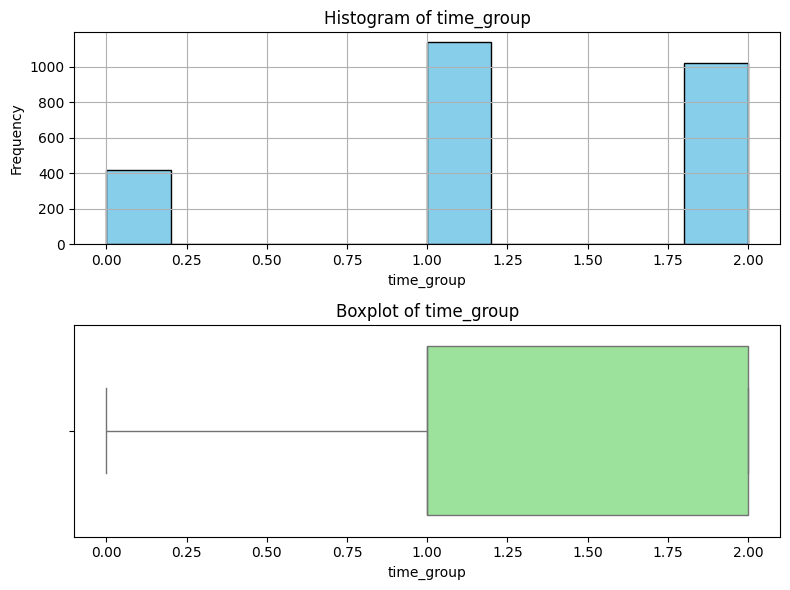

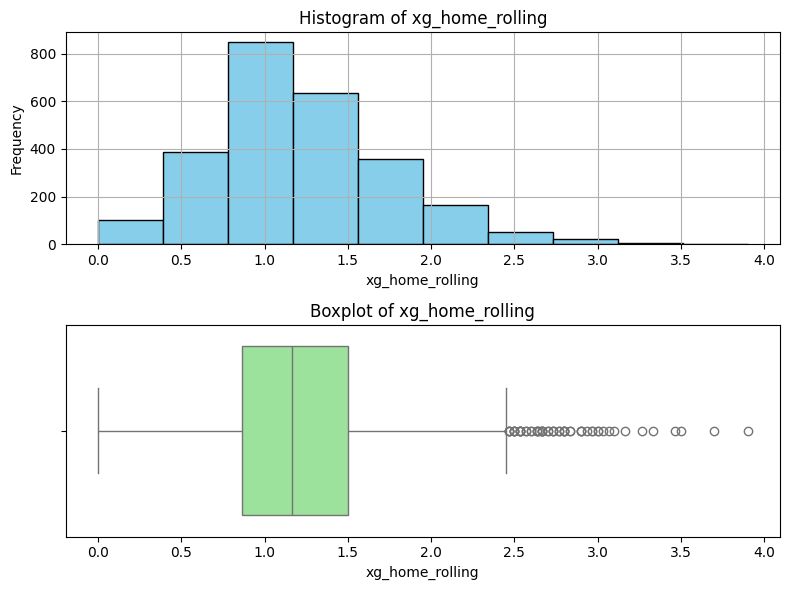

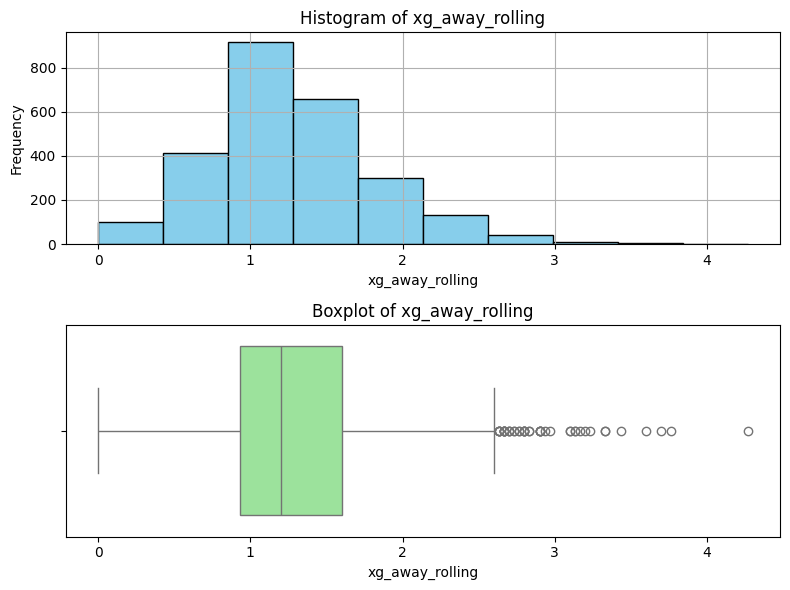

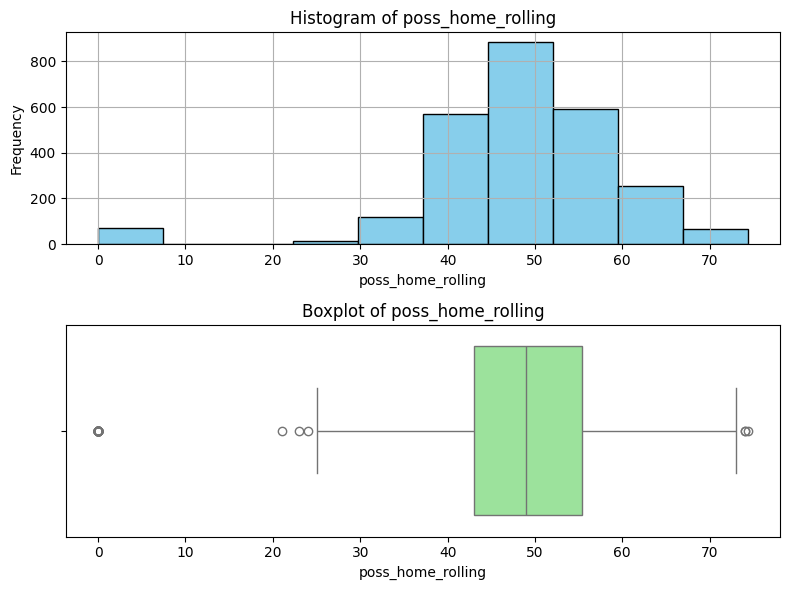

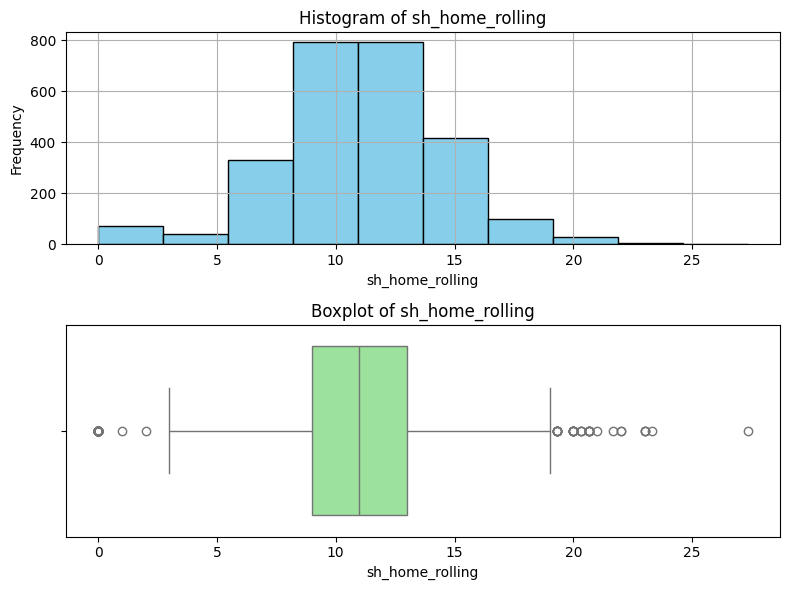

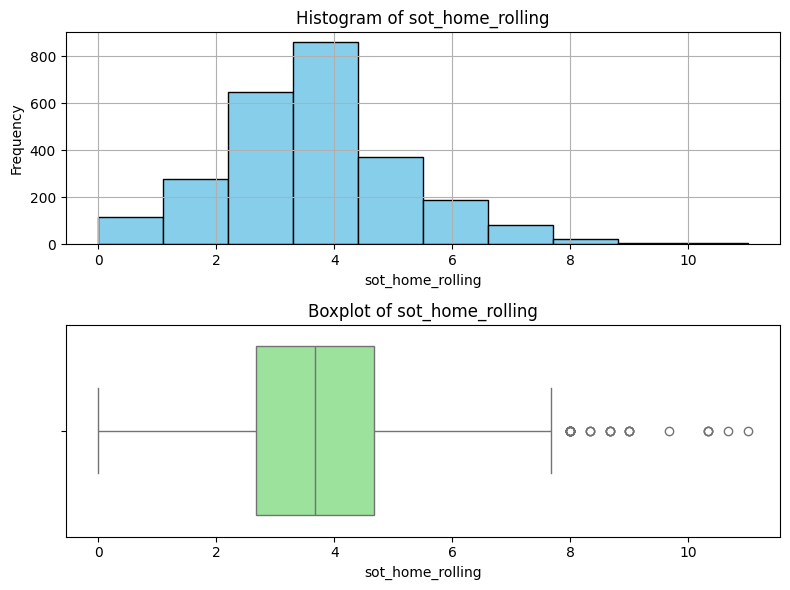

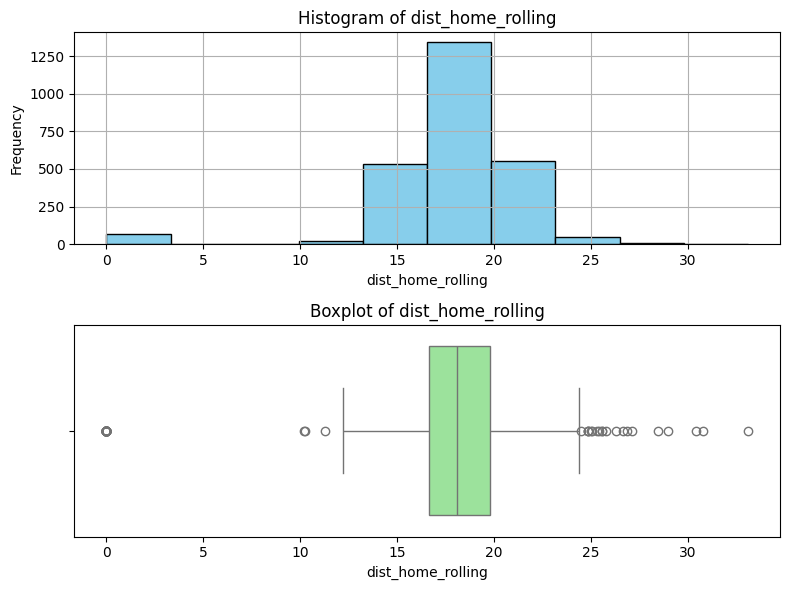

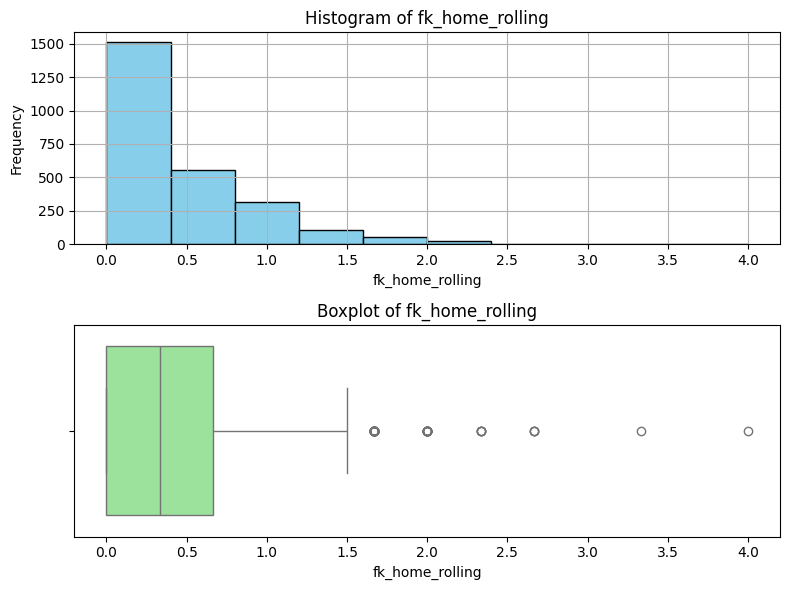

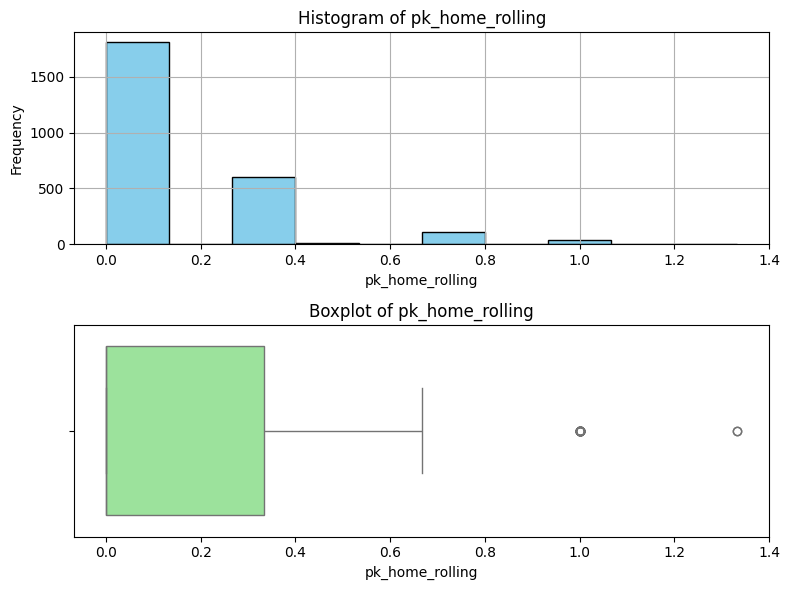

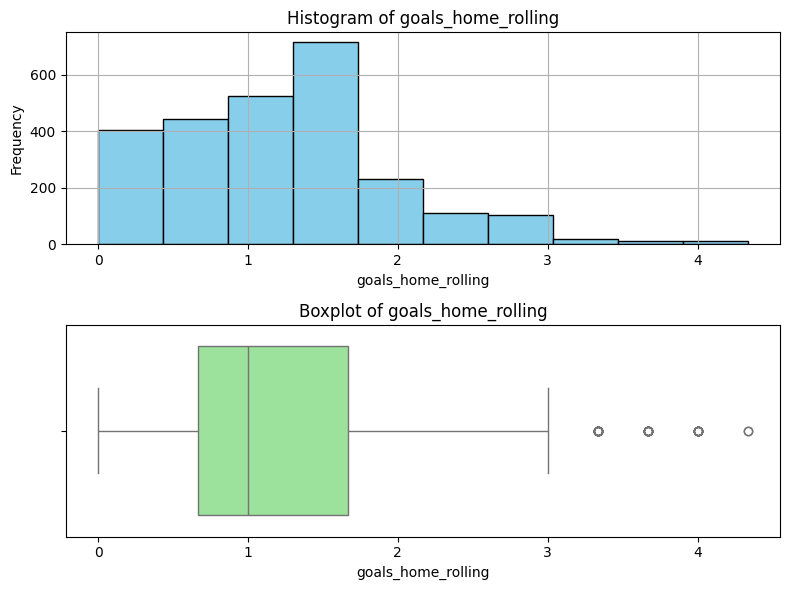

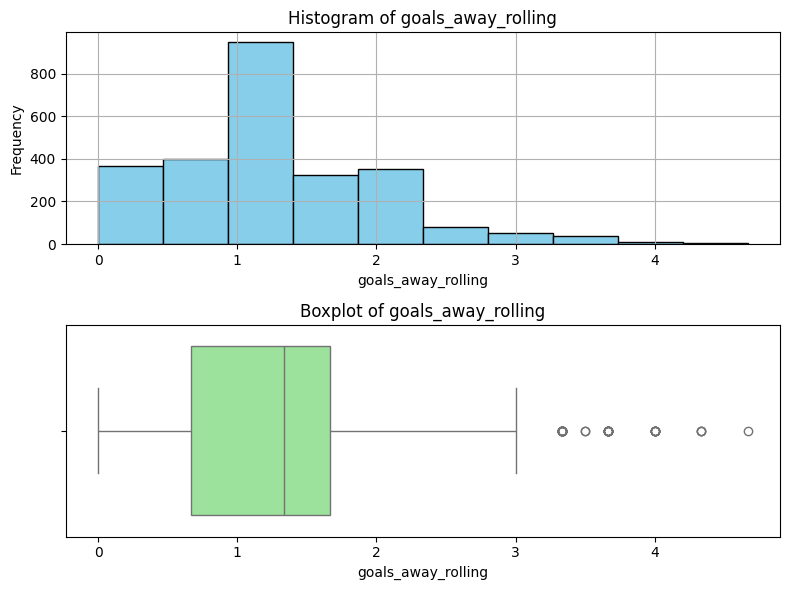

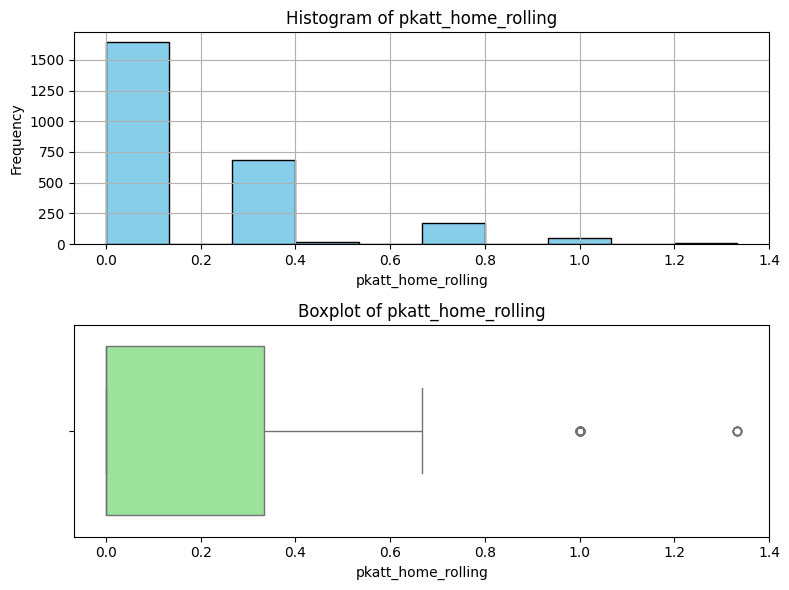

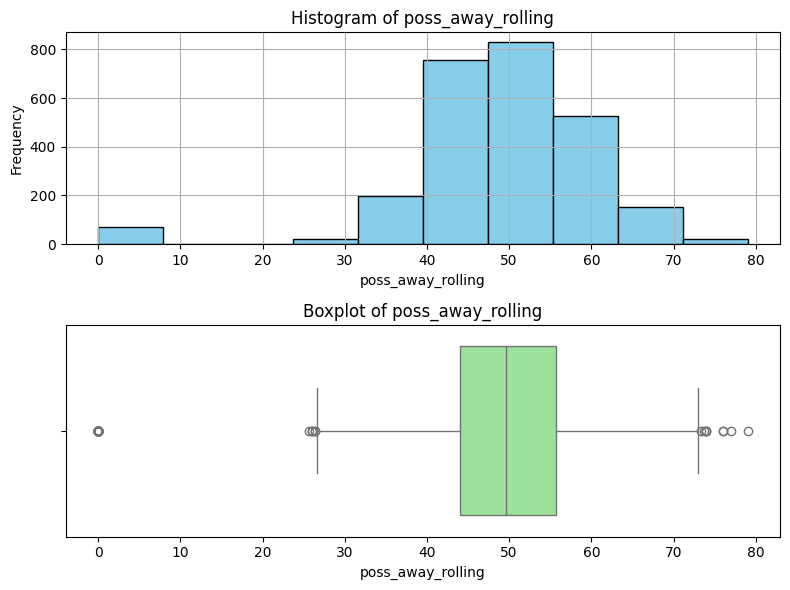

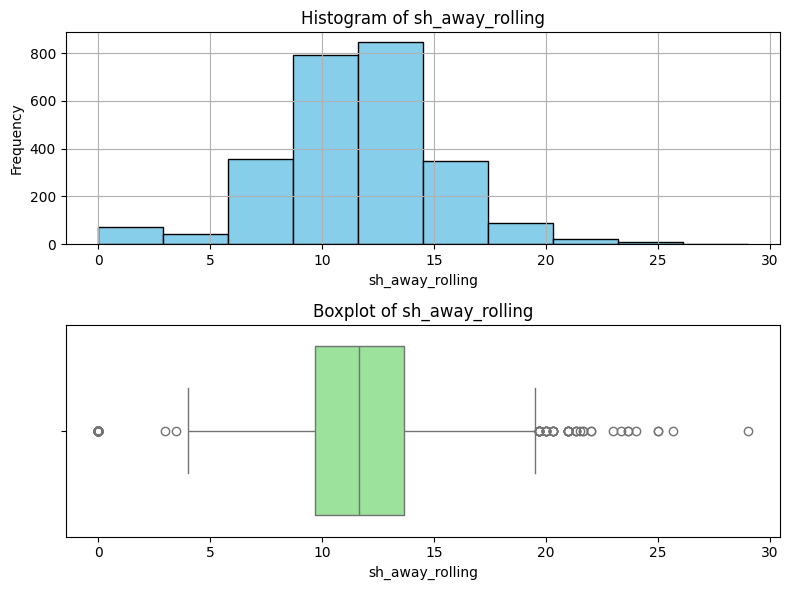

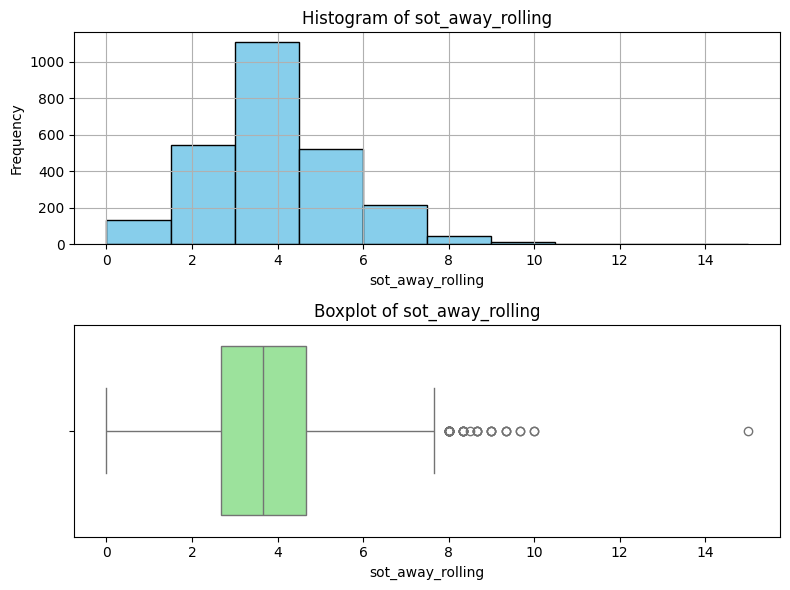

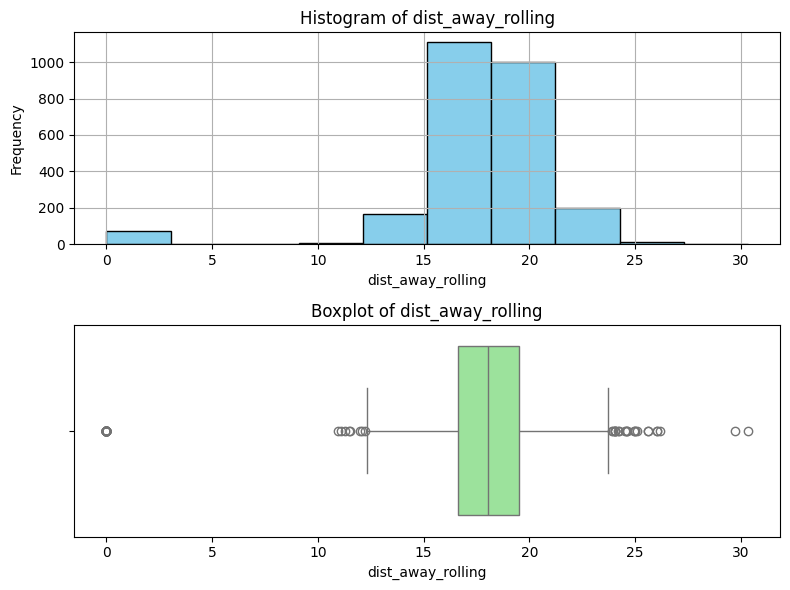

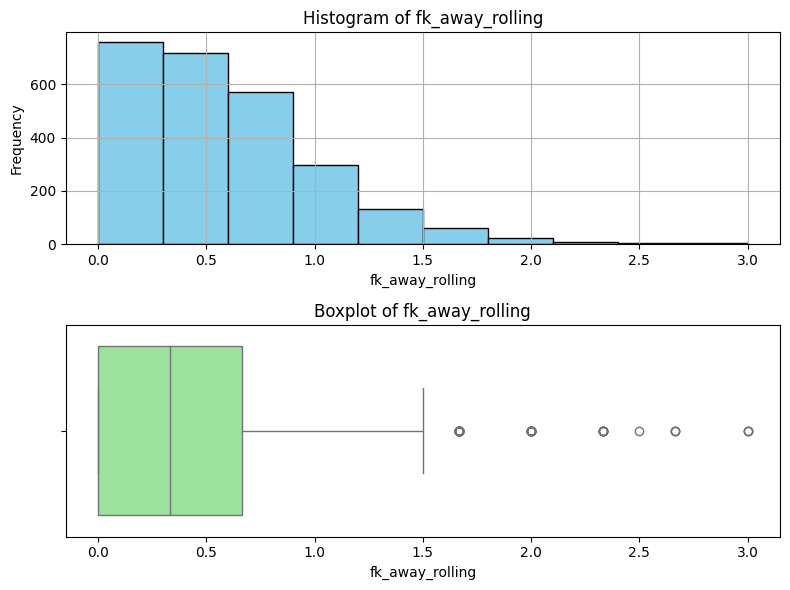

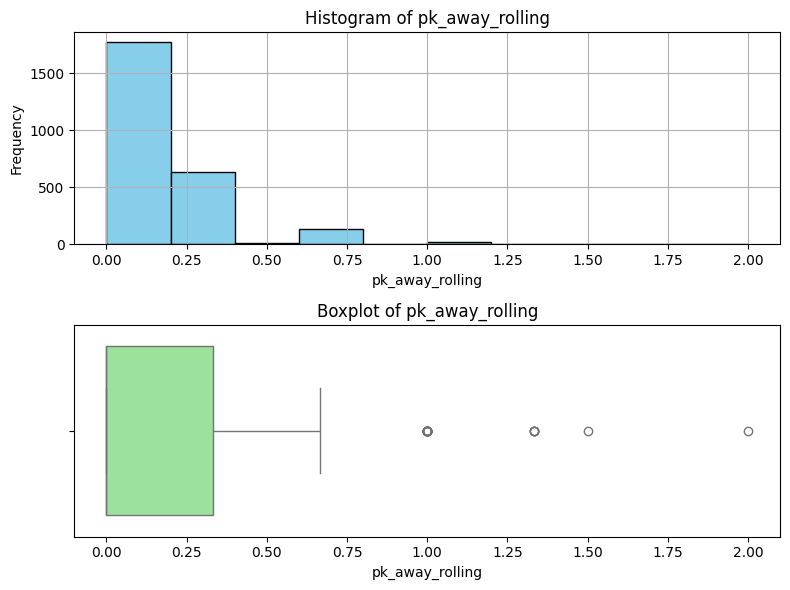

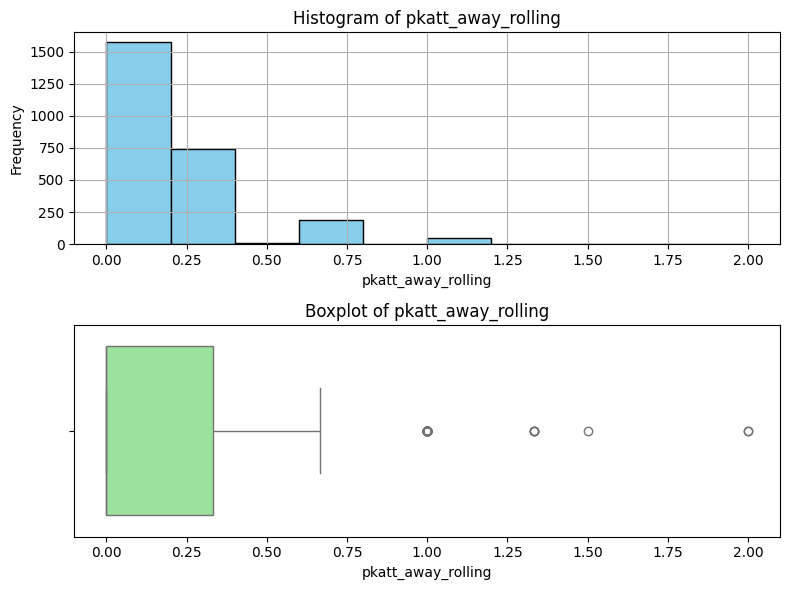

In [22]:
for column in df_rolling[features].columns:
    plt.figure(figsize=(8, 6))
    
    # Histogram
    plt.subplot(2, 1, 1)
    df_rolling[column].hist(color='skyblue', edgecolor='black')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.title(f'Histogram of {column}')
    
    # Boxplot
    plt.subplot(2, 1, 2)
    sns.boxplot(x=df_rolling[column], color='lightgreen')
    plt.xlabel(column)
    plt.title(f'Boxplot of {column}')
    
    plt.tight_layout()
    plt.show()

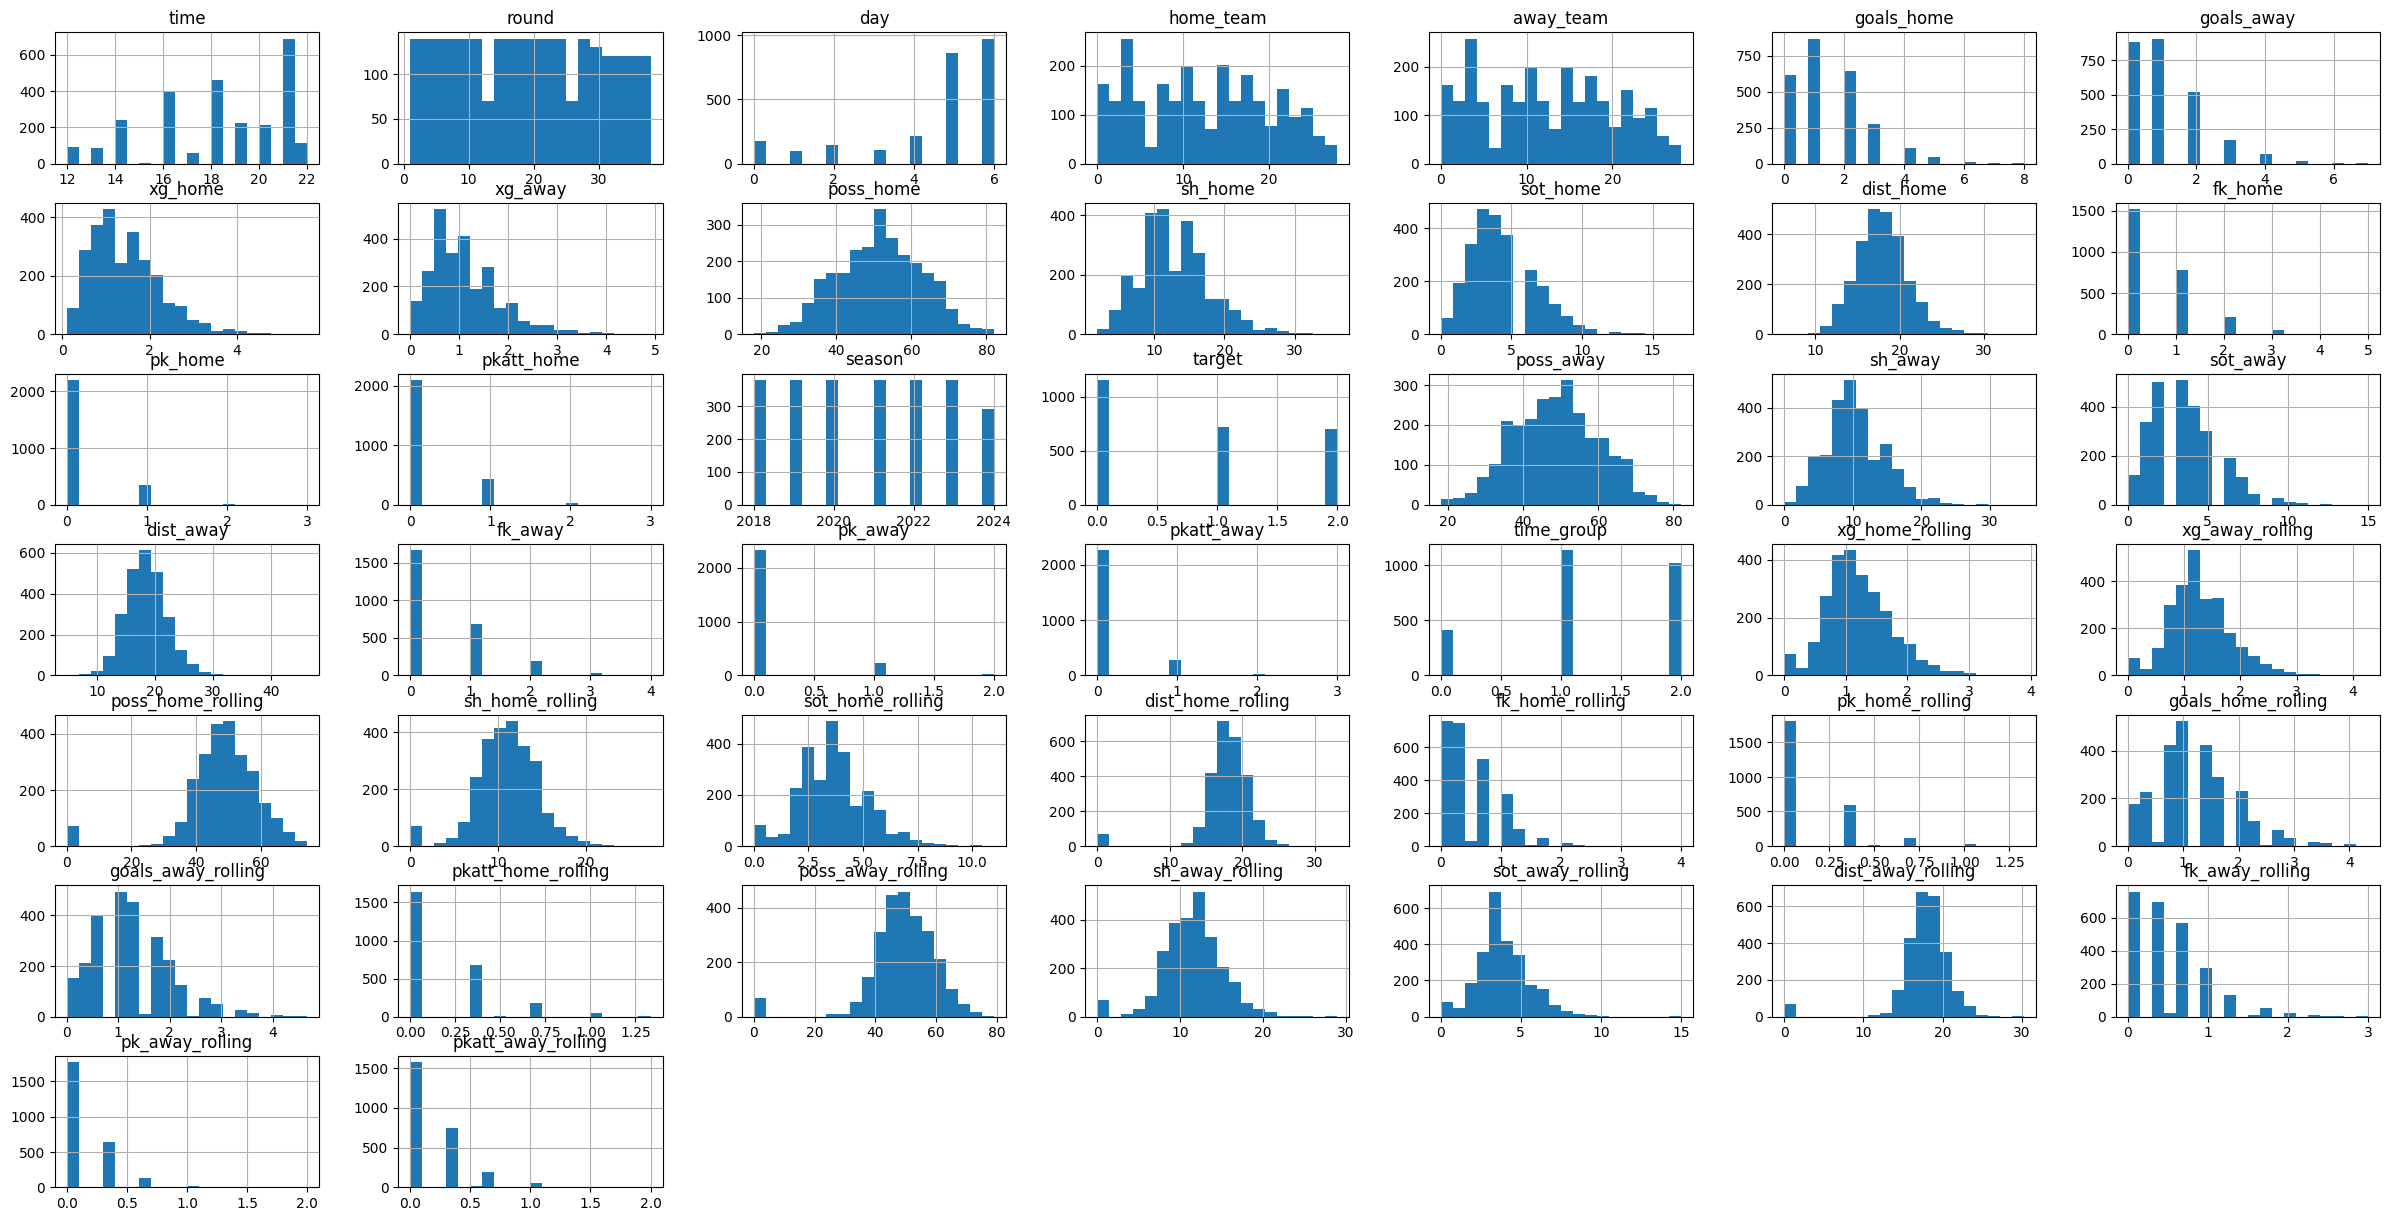

In [23]:
df_rolling.hist(figsize= (30, 15),bins = 20);

In [24]:
correlation_matrix = pd.concat([X, y], axis=1).corr()

In [25]:
num_cols = len(correlation_matrix.columns) -1 
cols_per_subplot = num_cols // 3

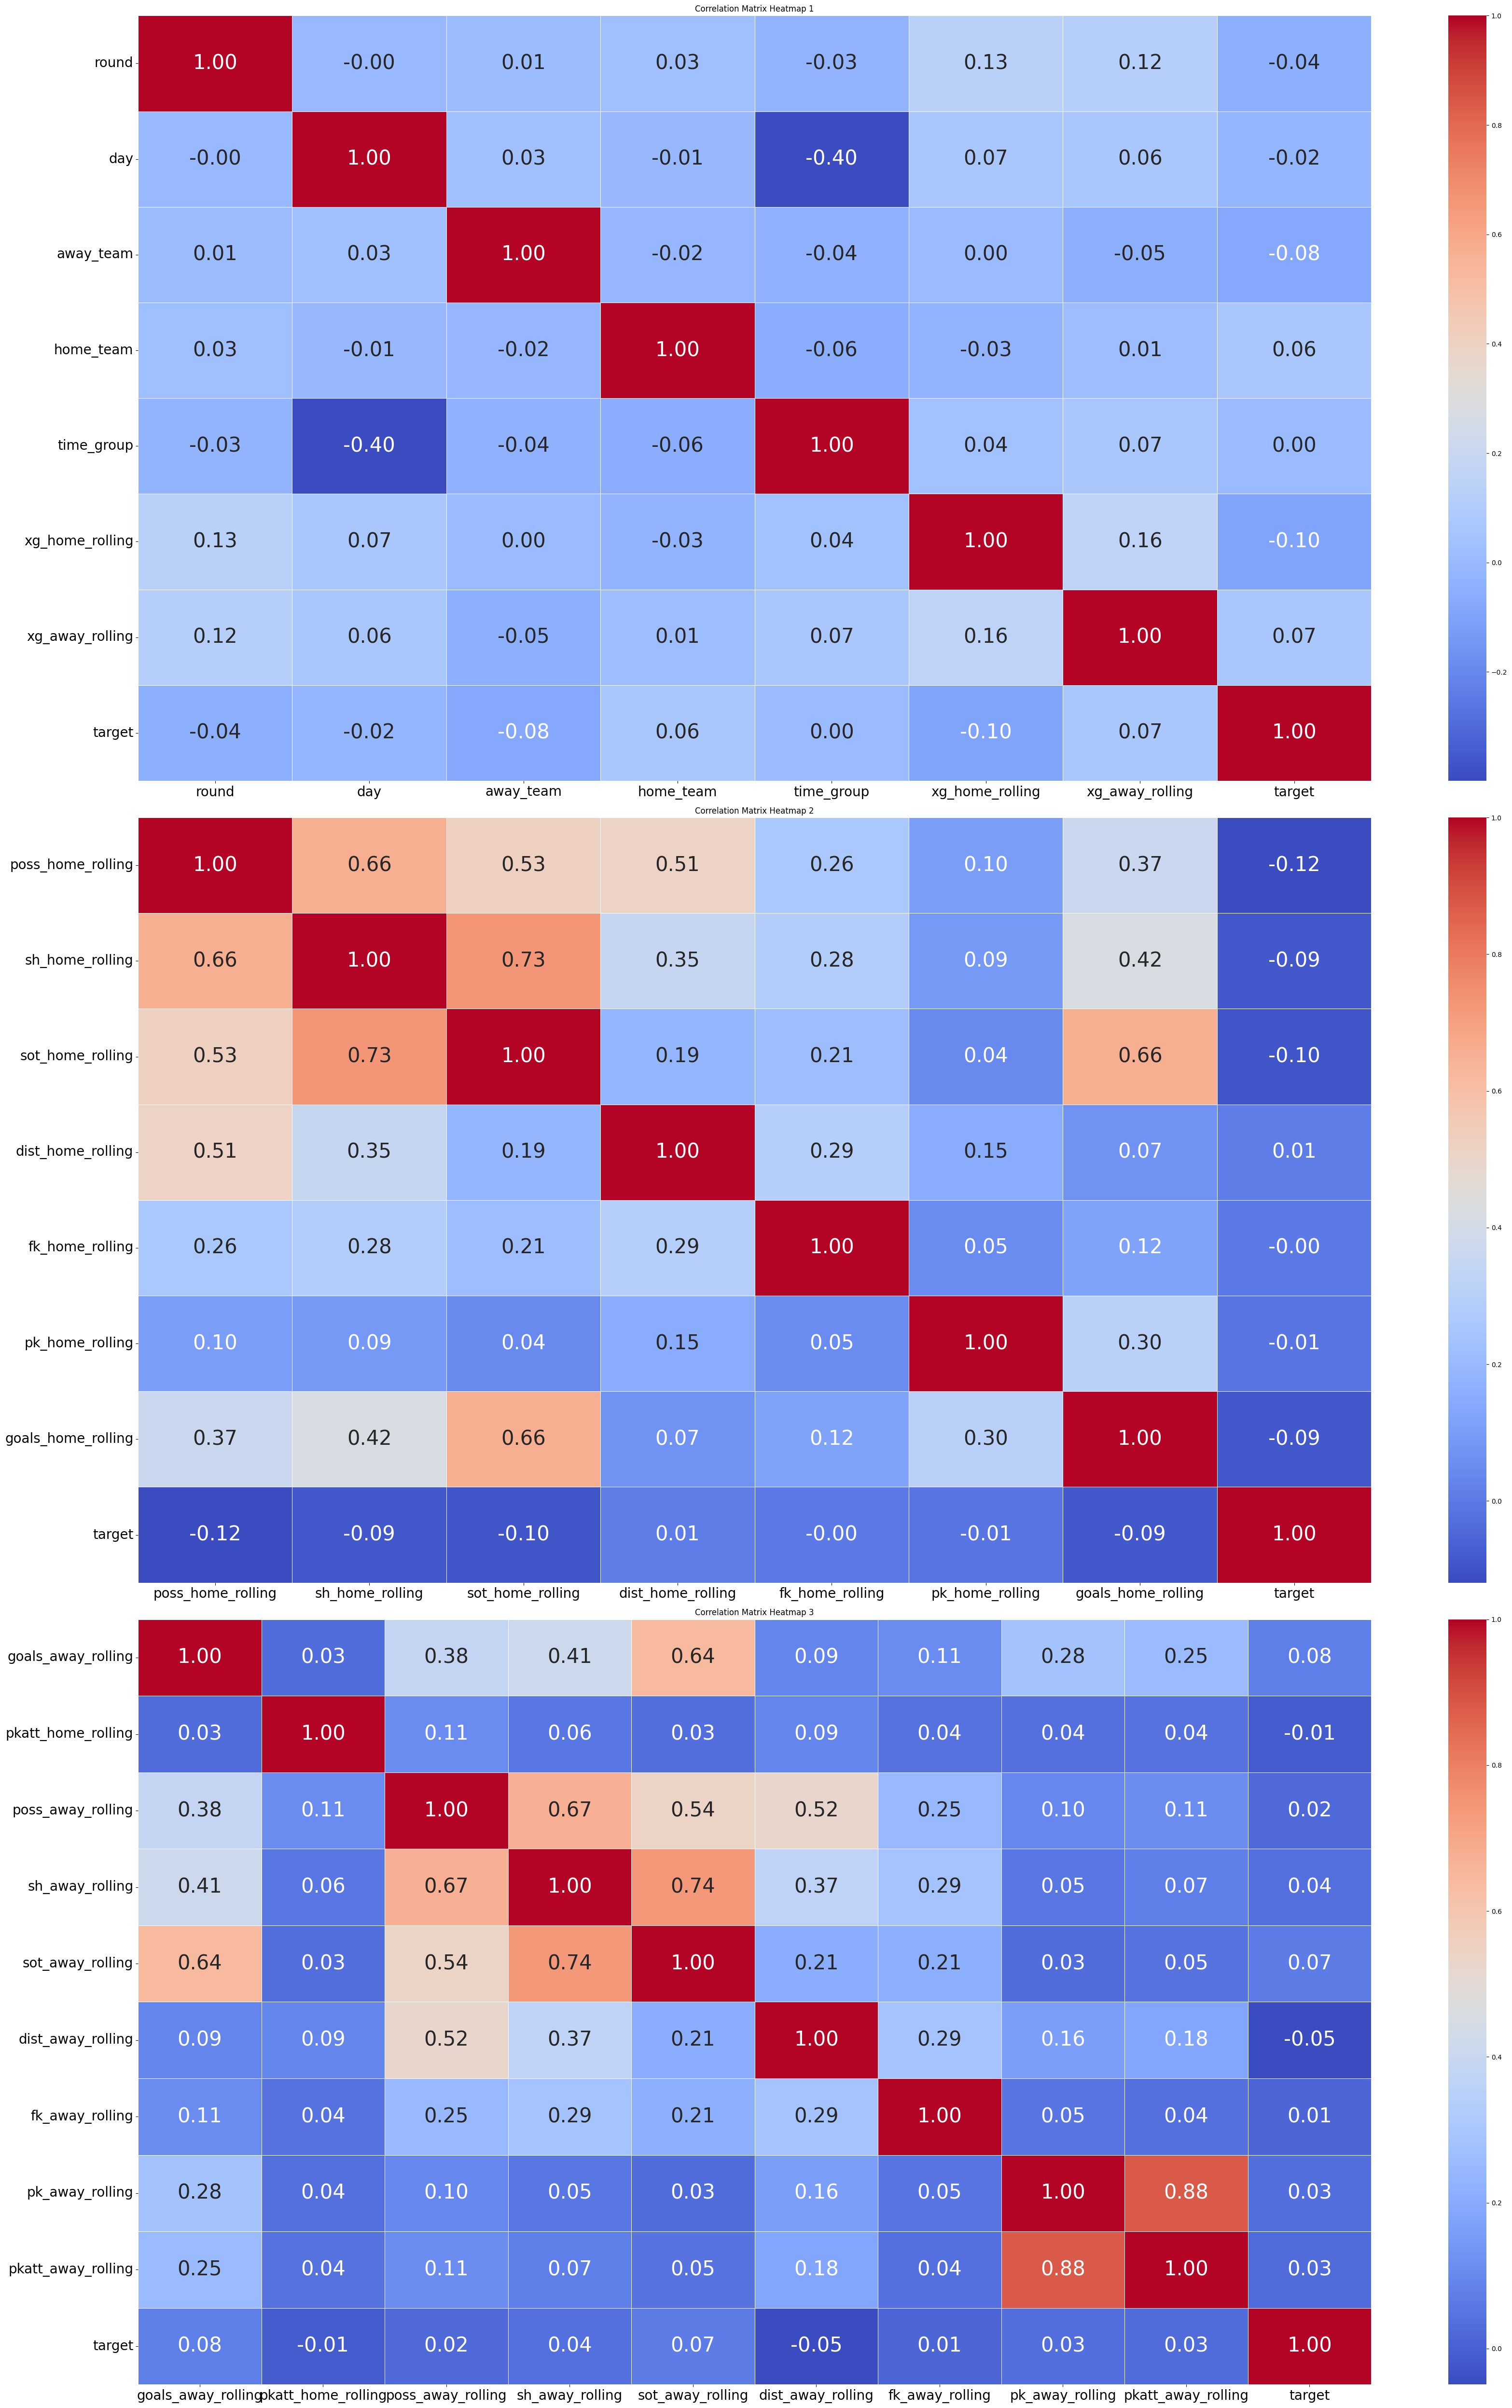

In [27]:
# Plotting the correlation matrices in three subplots
fig, axes = plt.subplots(3, 1, figsize=(35, 50))
plt.subplots_adjust(wspace=0.4, hspace=1)

for i, ax in enumerate(axes):
    start_col = i * cols_per_subplot
    end_col = (i + 1) * cols_per_subplot if i != 2 else None  # Adjust the end column for the last subset
    
    # Include the target variable in each subset, excluding it from the last subset
    subset_cols = correlation_matrix.columns[start_col:end_col]
    if i != 2:
        subset_cols = subset_cols.append(pd.Index(["target"]))
        
    subset_corr_matrix = correlation_matrix.loc[subset_cols, subset_cols]
    
    sns.heatmap(subset_corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, ax=ax, annot_kws={"size": 30})
    ax.set_title(f'Correlation Matrix Heatmap {i + 1}')

  # Adjusting font size for axis labels and ticks
    ax.tick_params(axis='both', which='major', labelsize=20)  # Adjust font size for tick labels
    ax.tick_params(axis='both', which='minor', labelsize=20)  # Adjust font size for tick labels
    ax.set_xlabel(ax.get_xlabel(), fontsize=30)  # Adjust font size for x-axis label
    ax.set_ylabel(ax.get_ylabel(), fontsize=30)  # Adjust font size for y-axis label

plt.tight_layout()
plt.show()

## 8. First model <a id="firstmodel"></a>

### After viewing our features, we will proceed to make a baseline for our model. For this I have chosen a random forest to perform our first model. Since our classes are unbalanced, we will aim for f1 score as our metric to evaluate the model. However, we will keep a close eye on the accuracy as we go.

In [34]:
rf_classifier = RandomForestClassifier(random_state=42) #no hyperparameters being tuned for now.

In [35]:
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [36]:
y_pred = rf_classifier.predict(X_test)

In [37]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.52      0.75      0.62       234
           1       0.48      0.44      0.46       133
           2       0.25      0.10      0.14       147

    accuracy                           0.48       514
   macro avg       0.42      0.43      0.41       514
weighted avg       0.44      0.48      0.44       514



### Our first model returned a 41% f1-score which is considerably low. It did get a higher accuracy at 48% We will now proceed to tune the hyperparameters of the random forest in order to improve our metric.

In [40]:
f1_weighted_scorer = make_scorer(f1_score, average='macro') #we create the f1-score variable to pass it on to the gridsearch, we use macro to give al classes the same weight

In [164]:
# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],    # Maximum depth of the trees
    'min_samples_split': [2, 5, 10],    # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4]       # Minimum number of samples required at each leaf node
}

# Create Random Forest classifier
rf_classifier = RandomForestClassifier()

# Create GridSearchCV object with the Random Forest classifier and parameter grid
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, scoring=f1_weighted_scorer, n_jobs = -1)

# Perform grid search to find the best parameters
grid_search.fit(X_train, y_train)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)


Best Parameters: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best Score: 0.38650676993220495


In [42]:
rf_classifier = RandomForestClassifier(**best_params, random_state = 42)

In [43]:
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(min_samples_leaf=2, min_samples_split=10,
                       random_state=42)

In [44]:
y_pred = rf_classifier.predict(X_test)

In [45]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.50      0.77      0.61       234
           1       0.46      0.38      0.42       133
           2       0.27      0.08      0.13       147

    accuracy                           0.47       514
   macro avg       0.41      0.41      0.38       514
weighted avg       0.42      0.47      0.42       514



### Our f1-score has decreased to 40% and the accuracy remained the same, we did not manage to make any real improvement. Lets try including the categorical data by giving numeric values or labels, to each referee and formation.

## 9. Adding new features <a id="addfeature"></a>

In [46]:
referee = df_rolling["referee"].unique() #extract the unique names of all the refs.

In [47]:
ref_dict = {ref: index for index, ref in enumerate(referee)} #create a dictionary to map them.

In [48]:
df_rolling["ref_coded"] = df_rolling["referee"].replace(ref_dict) #create new numeric column to map referee.

In [49]:
formations = pd.concat([df_rolling['formation_home'], df_rolling['formation_away']]).unique() #extract all formations

In [50]:
form_dict = {form: index for index, form in enumerate(formations)} #create dictionary to map it

In [51]:
df_rolling["formation_coded_home"] = df_rolling["formation_home"].replace(form_dict) #create new numeric column to map formations.

In [52]:
df_rolling["formation_coded_away"] = df_rolling["formation_away"].replace(form_dict) #create new numeric column to map formations.

### lets retrain our model with the new columns we have created.

In [53]:
features = ["round", "day", "away_team", "home_team", "time_group", 'xg_home_rolling', 'xg_away_rolling', 'poss_home_rolling', 'sh_home_rolling',
 'sot_home_rolling', 'dist_home_rolling', 'fk_home_rolling', 'pk_home_rolling', 'goals_home_rolling', 'goals_away_rolling', 'pkatt_home_rolling',
 'poss_away_rolling', 'sh_away_rolling', 'sot_away_rolling', 'dist_away_rolling', 'fk_away_rolling', 'pk_away_rolling', 'pkatt_away_rolling','ref_coded',
'formation_coded_home', 'formation_coded_away']

In [54]:
X = df_rolling[features]
y = df_rolling['target']

In [55]:
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=42)

In [56]:
# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],    # Maximum depth of the trees
    'min_samples_split': [2, 5, 10],    # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4],
    'class_weight' : ['balanced']
    # Minimum number of samples required at each leaf node
}

# Create Random Forest classifier
rf_classifier = RandomForestClassifier()

# Create GridSearchCV object with the Random Forest classifier and parameter grid
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, scoring=f1_weighted_scorer)

# Perform grid search to find the best parameters
grid_search.fit(X_train, y_train)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

Best Parameters: {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best Score: 0.4106027240649519


In [57]:
rf_classifier = RandomForestClassifier(class_weight = 'balanced', max_depth= 20, min_samples_leaf = 1, min_samples_split = 5, n_estimators = 100, random_state=42)

In [58]:
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=20,
                       min_samples_split=5, random_state=42)

In [59]:
y_pred = rf_classifier.predict(X_test)

In [60]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.53      0.73      0.61       234
           1       0.45      0.45      0.45       133
           2       0.33      0.13      0.19       147

    accuracy                           0.48       514
   macro avg       0.43      0.44      0.42       514
weighted avg       0.45      0.48      0.45       514



### We seem to be having poor results with the random forest. There have been no mayor improvements (just 1% improvement with the new data) lets expand to multiple models and see other results. We will also scale the data for better results in other models.

## 10. Multiple model training <a id="multimodel"></a>

In [61]:
train_set, test_set = train_test_split(df_rolling, test_size= 0.2, random_state= 42)

In [62]:
scaler = StandardScaler()
X_train = train_set[features]
y_train = train_set["target"]
X_test = test_set[features]
y_test = test_set["target"]
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns= features)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns = features)

### This will be our new baseline with all the features being trained with 9 different models before optimizing them.

In [63]:
model_names = ["Logistic Regression","DecisionTree","Random Forest","XGBoost","LightGBM","CatBoost","KNN", "SVM", "AdaBoost"]
lr_clf = LogisticRegression(max_iter = 10000)
tree_clf = DecisionTreeClassifier(random_state= 42)
rf_clf = RandomForestClassifier(random_state= 42)
xgb_clf = XGBClassifier(random_state = 42)
lgb_clf = LGBMClassifier(random_state= 42, verbose = -100)
cat_clf = CatBoostClassifier(random_state= 42, verbose = False)
knn_clf = KNeighborsClassifier()
svm_clf = SVC(random_state=42)
adaboost_clf = AdaBoostClassifier(random_state=42)

model_set = [lr_clf, tree_clf, rf_clf, xgb_clf, lgb_clf, cat_clf, knn_clf, svm_clf, adaboost_clf]


In [64]:
metrics_cv = {}
values = []
for name,model in zip(model_names, model_set):
    print(model)
    if name != "Logistic Regression":
        metrics_cv[name] = cross_val_score(model, X_train, y_train, cv = 5, scoring = f1_weighted_scorer)
    else:
        metrics_cv[name] = cross_val_score(model, X_train_scaled, y_train, cv = 5, scoring = f1_weighted_scorer)
    values.append(np.mean(metrics_cv[name]))
winner = list(metrics_cv.keys())[np.argmax(values)]

LogisticRegression(max_iter=10000)
DecisionTreeClassifier(random_state=42)
RandomForestClassifier(random_state=42)
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)
LGBMClassifier(random_state=42, verbose=-100)
KNeighborsClassifier()
SVC(random_state=42)
AdaBoostClassifier(random_state=42)


In [65]:
for model_name, values in metrics_cv.items():
    print(f"Model <{model_name}>, F1_weighted: {np.mean(values)}")
print(f"The winner is {winner}")

Model <Logistic Regression>, F1_weighted: 0.368547413516862
Model <DecisionTree>, F1_weighted: 0.3618261746668955
Model <Random Forest>, F1_weighted: 0.36371329083686316
Model <XGBoost>, F1_weighted: 0.3727769432031634
Model <LightGBM>, F1_weighted: 0.3714069431983475
Model <CatBoost>, F1_weighted: 0.36785895189953727
Model <KNN>, F1_weighted: 0.36209085771974925
Model <SVM>, F1_weighted: 0.30274790424836906
Model <AdaBoost>, F1_weighted: 0.379677869424642
The winner is AdaBoost


### The score drastically decreased, we will now proceed to optimize all models in order to get a better idea of where we stand.

In [66]:
optimized_metrics = {}

In [67]:
LogisticRegression
param_grid = {
    "max_iter": [100,1000, 2000, 5000, 10000],
    "penalty": ["l2",None],
    "C": [0.1,0.5,1],

} # 4*3*3 -> 36 modelos
model = LogisticRegression()
lr_grid = RandomizedSearchCV( model,
                             cv = 5,
                             n_iter = 20,
                             param_distributions= param_grid,
                             scoring= f1_weighted_scorer
)

lr_grid.fit(X_train_scaled,y_train)
print("LR best_score:", lr_grid.best_score_)
optimized_metrics["LogisticRegression"] = lr_grid.best_score_
# Get the best estimator
best_lr_model = lr_grid.best_estimator_

# Make predictions on the test set
y_pred = best_lr_model.predict(X_test_scaled)

# Generate the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

LR best_score: 0.368547413516862
Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.79      0.62       234
           1       0.40      0.38      0.39       133
           2       0.35      0.07      0.12       147

    accuracy                           0.48       514
   macro avg       0.42      0.41      0.38       514
weighted avg       0.44      0.48      0.42       514



In [68]:
### DecisionTrees

tree_clf = DecisionTreeClassifier()

param_grid = {
    "max_depth": [1,2,4,8,None],
    "min_samples_leaf": [1,5,10,20],
    "max_features": ["sqrt","log2", None]
}

tree_grid = RandomizedSearchCV(tree_clf, 
                               cv = 5,
                               n_iter = 20,
                               param_distributions= param_grid, 
                               scoring = f1_weighted_scorer)

tree_grid.fit(X_train,y_train)
print("Tree best_score:", tree_grid.best_score_)
optimized_metrics["Tree"] = tree_grid.best_score_
# Get the best estimator
best_tree_model = tree_grid.best_estimator_

# Make predictions on the test set
y_pred = best_tree_model.predict(X_test_scaled)

# Generate the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Tree best_score: 0.37728157537909995
Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.88      0.58       234
           1       0.24      0.08      0.12       133
           2       0.00      0.00      0.00       147

    accuracy                           0.42       514
   macro avg       0.23      0.32      0.24       514
weighted avg       0.26      0.42      0.30       514



In [69]:
### RandomForest

rf_clf = RandomForestClassifier()

params_grid = {
    "n_estimators": [100,200,300,400],
    "max_depth": [None,2,4,10,20,30],
    "min_samples_leaf": [1,2,5, 10,20,40],
    "min_samples_split": [2, 5, 10],
    "max_features": ['auto', "sqrt","log2",None],
    "max_samples": [None,0.3,0.6,1]
}

rf_grid = RandomizedSearchCV(rf_clf, 
                               cv = 5,
                               n_iter = 20,
                               param_distributions= param_grid, 
                               scoring = f1_weighted_scorer)


rf_grid.fit(X_train, y_train)
print("RF best_score:", rf_grid.best_score_)
optimized_metrics["RandomForest"] = rf_grid.best_score_

# Get the best estimator
best_rf_model = rf_grid.best_estimator_

# Make predictions on the test set
y_pred = best_rf_model.predict(X_test_scaled)

# Generate the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

RF best_score: 0.3670929954844345
Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.09      0.15       234
           1       0.30      0.05      0.09       133
           2       0.29      0.90      0.44       147

    accuracy                           0.31       514
   macro avg       0.38      0.35      0.23       514
weighted avg       0.41      0.31      0.22       514



In [70]:
### XGBoost

xgb_clf = XGBClassifier()

param_grid = {'max_depth': [3, 6, 10, 15],
          'learning_rate': [0.1, 0.2, 0.3, 0.4],
          'subsample': np.arange(0.5, 1.0, 0.1),
          'colsample_bytree': np.arange(0.5, 1.0, 0.1),
          'colsample_bylevel': np.arange(0.5, 1.0, 0.1),
          'n_estimators': [100, 250, 500, 750],
          }

xgb_grid = RandomizedSearchCV(xgb_clf, 
                               cv = 5,
                               n_iter = 20,
                               param_distributions= param_grid, 
                               scoring = f1_weighted_scorer)


xgb_grid.fit(X_train, y_train)
print("XGB best_score:", xgb_grid.best_score_)
optimized_metrics["XGBoost"] = xgb_grid.best_score_

# Get the best estimator
best_xgb_model = xgb_grid.best_estimator_

# Make predictions on the test set
y_pred = best_xgb_model.predict(X_test_scaled)

# Generate the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

XGB best_score: 0.39936982871060955
Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.01      0.03       234
           1       0.00      0.00      0.00       133
           2       0.28      0.99      0.44       147

    accuracy                           0.29       514
   macro avg       0.29      0.33      0.16       514
weighted avg       0.35      0.29      0.14       514



In [71]:
### LightGBM 


lgb_clf = LGBMClassifier(verbose = -100)

param_grid= {'max_depth': [-1,3, 6, 12],
          'learning_rate': [0.1, 0.2, 0.3, 0.4],
          'bagging_fraction': [0.3,0.6,1],
          'feature_fraction': [0.5,1],
          'n_estimators': [100, 250, 500, 750],
          'max_bins': [125,255]
          }

lgb_grid = RandomizedSearchCV(lgb_clf, 
                               cv = 5,
                               n_iter = 20,
                               param_distributions= param_grid, 
                               scoring = f1_weighted_scorer)


lgb_grid.fit(X_train, y_train)
print("LGB best_score:", lgb_grid.best_score_)
optimized_metrics["LightGBM"] = lgb_grid.best_score_

# Get the best estimator
best_lgb_model = lgb_grid.best_estimator_

# Make predictions on the test set
y_pred = best_lgb_model.predict(X_test_scaled)

# Generate the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

LGB best_score: 0.3941729579385783
Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.72      0.60       234
           1       0.26      0.07      0.11       133
           2       0.31      0.32      0.32       147

    accuracy                           0.44       514
   macro avg       0.36      0.37      0.34       514
weighted avg       0.39      0.44      0.39       514



In [72]:
### CatBoost

cat_clf = CatBoostClassifier(verbose = False)

param_grid= {'depth': [3, 6, 12],
          'learning_rate': [0.1, 0.2, 0.3, 0.4],
          'colsample_bylevel': [0.5,1, None],
          'iterations': [100, 250, 500, 750, 1000],
          "border_count": [125,254]
          }


cat_grid = RandomizedSearchCV(cat_clf, 
                               cv = 5,
                               n_iter = 3,
                               param_distributions= param_grid, 
                               scoring = f1_weighted_scorer)


cat_grid.fit(X_train, y_train)
print("CatBoost best_score:", cat_grid.best_score_)
optimized_metrics["CatBoost"] = cat_grid.best_score_

# Get the best estimator
best_cat_model = cat_grid.best_estimator_

# Make predictions on the test set
y_pred = best_cat_model.predict(X_test_scaled)

# Generate the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

CatBoost best_score: 0.38624603175328515
Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.12      0.20       234
           1       0.23      0.20      0.21       133
           2       0.28      0.67      0.39       147

    accuracy                           0.30       514
   macro avg       0.38      0.33      0.27       514
weighted avg       0.42      0.30      0.26       514



In [73]:
# KNN

knn_clf = KNeighborsClassifier()

param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'p': [1, 2]
}

knn_grid = RandomizedSearchCV(knn_clf, 
                              param_distributions=param_grid,
                              n_iter=20,
                              cv=5,
                              scoring=f1_weighted_scorer,
                              random_state=42)

knn_grid.fit(X_train_scaled, y_train)
print("KNN best_score:", knn_grid.best_score_)
optimized_metrics["KNN"] = knn_grid.best_score_

# Get the best estimator
best_knn_model = knn_grid.best_estimator_

# Make predictions on the test set
y_pred = best_knn_model.predict(X_test_scaled)

# Generate the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

KNN best_score: 0.363265002848152
Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.64      0.57       234
           1       0.38      0.35      0.36       133
           2       0.33      0.22      0.27       147

    accuracy                           0.45       514
   macro avg       0.41      0.40      0.40       514
weighted avg       0.43      0.45      0.43       514



In [74]:
# SVM
svm_clf = SVC()

param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'gamma': ['scale', 'auto']
}

svm_grid = RandomizedSearchCV(svm_clf, 
                              param_distributions=param_grid,
                              n_iter=20,
                              cv=5,
                              scoring=f1_weighted_scorer,
                              random_state=42)

svm_grid.fit(X_train_scaled, y_train)
print("SVM best_score:", svm_grid.best_score_)
optimized_metrics["SVM"] = svm_grid.best_score_

# Get the best estimator
best_svm_model = svm_grid.best_estimator_

# Make predictions on the test set
y_pred = best_svm_model.predict(X_test_scaled)

# Generate the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

SVM best_score: 0.36831485680607556
Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.59      0.54       234
           1       0.35      0.33      0.34       133
           2       0.27      0.20      0.23       147

    accuracy                           0.41       514
   macro avg       0.37      0.37      0.37       514
weighted avg       0.39      0.41      0.40       514



In [75]:
#adaboost

adaboost_clf = AdaBoostClassifier()

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1.0],
    'algorithm': ['SAMME', 'SAMME.R']
}

adaboost_grid = RandomizedSearchCV(adaboost_clf, 
                                   param_distributions=param_grid,
                                   n_iter=20,
                                   cv=5,
                                   scoring=f1_weighted_scorer,
                                   random_state=42)

adaboost_grid.fit(X_train_scaled, y_train)
print("AdaBoost best_score:", adaboost_grid.best_score_)
optimized_metrics["AdaBoost"] = adaboost_grid.best_score_

# Get the best estimator
best_ada_model = adaboost_grid.best_estimator_

# Make predictions on the test set
y_pred = best_ada_model.predict(X_test_scaled)

# Generate the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

AdaBoost best_score: 0.3891369683510993
Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.67      0.58       234
           1       0.43      0.38      0.41       133
           2       0.27      0.18      0.21       147

    accuracy                           0.45       514
   macro avg       0.41      0.41      0.40       514
weighted avg       0.43      0.45      0.43       514



## 11. One-hot encoding<a id="onehot"></a>

### The models are struggling with the data, the f1-score is quite poor overall and the accuracy isnt good either. It is possible that changing the teams to numeric values is causing a negative impact. Lets revert this to the original names and perform a one-hot encoding instead. We will also perform this for the referee column. 

In [76]:
df2 = df_rolling.copy() #lets create a copy of df_rolling so we have one dataset with numeric teams and the other one with the one hot encoding.

In [77]:
dict_teams_inverted = {v: k for k, v in dict_teams.items()} #we invert the dictionary
df2["home_team"] = df2["home_team"].replace(dict_teams_inverted) #apply the inverted dictionary to home and away columns
df2["away_team"] = df2["away_team"].replace(dict_teams_inverted)

In [78]:
one_hot_encoded = pd.get_dummies(df2[['home_team', 'away_team', 'referee']]) #perform the encoding for the 3 features
df2 = pd.concat([df2, one_hot_encoded], axis=1)

In [79]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2570 entries, 0 to 2579
Columns: 146 entries, date to referee_Xavi Estrada
dtypes: bool(95), float64(32), int64(13), object(6)
memory usage: 1.3+ MB


In [80]:
features =  [
 'round',
 'day',
 'season',
 'time_group',
 'xg_home_rolling',
 'xg_away_rolling',
 'poss_home_rolling',
 'sh_home_rolling',
 'sot_home_rolling',
 'dist_home_rolling',
 'fk_home_rolling',
 'pk_home_rolling',
 'goals_home_rolling',
 'goals_away_rolling',
 'pkatt_home_rolling',
 'poss_away_rolling',
 'sh_away_rolling',
 'sot_away_rolling',
 'dist_away_rolling',
 'fk_away_rolling',
 'pk_away_rolling',
 'pkatt_away_rolling',
 'formation_coded_home',
 'formation_coded_away',
 'home_team_Alaves',
 'home_team_Almeria',
 'home_team_Athletic Club',
 'home_team_Atletico Madrid',
 'home_team_Barcelona',
 'home_team_Cadiz',
 'home_team_Celta Vigo',
 'home_team_Deportivo La Coruna',
 'home_team_Eibar',
 'home_team_Elche',
 'home_team_Espanyol',
 'home_team_Getafe',
 'home_team_Girona',
 'home_team_Granada',
 'home_team_Huesca',
 'home_team_Las Palmas',
 'home_team_Leganes',
 'home_team_Levante',
 'home_team_Malaga',
 'home_team_Mallorca',
 'home_team_Osasuna',
 'home_team_Rayo Vallecano',
 'home_team_Real Betis',
 'home_team_Real Madrid',
 'home_team_Real Sociedad',
 'home_team_Sevilla',
 'home_team_Valencia',
 'home_team_Valladolid',
 'home_team_Villarreal',
 'away_team_Alaves',
 'away_team_Almeria',
 'away_team_Athletic Club',
 'away_team_Atletico Madrid',
 'away_team_Barcelona',
 'away_team_Cadiz',
 'away_team_Celta Vigo',
 'away_team_Deportivo La Coruna',
 'away_team_Eibar',
 'away_team_Elche',
 'away_team_Espanyol',
 'away_team_Getafe',
 'away_team_Girona',
 'away_team_Granada',
 'away_team_Huesca',
 'away_team_Las Palmas',
 'away_team_Leganes',
 'away_team_Levante',
 'away_team_Malaga',
 'away_team_Mallorca',
 'away_team_Osasuna',
 'away_team_Rayo Vallecano',
 'away_team_Real Betis',
 'away_team_Real Madrid',
 'away_team_Real Sociedad',
 'away_team_Sevilla',
 'away_team_Valencia',
 'away_team_Valladolid',
 'away_team_Villarreal',
 'referee_Adrián Cordero',
 'referee_Alberola Rojas',
 'referee_Alberto Undiano',
 'referee_Alejandro Hernández',
 'referee_Alejandro Muñíz',
 'referee_Alfonso Álvarez',
 'referee_Antonio Matéu',
 'referee_Antonio Matéu Lahoz',
 'referee_Carlos del Cerro',
 'referee_César Soto',
 'referee_Daniel Trujillo',
 'referee_David Fernández',
 'referee_David Medié',
 'referee_Eduardo Prieto',
 'referee_Francisco Hernández',
 'referee_Guillermo Cuadra',
 'referee_Ignacio Iglesias',
 'referee_Isidro Díaz de Mera',
 'referee_Javier Estrada',
 'referee_Javier Villanueva',
 'referee_Jesús Gil',
 'referee_Jorge Figueroa',
 'referee_José González',
 'referee_José Luis Munuera',
 'referee_José Munuera',
 'referee_José Sánchez',
 'referee_Juan Martínez',
 'referee_Juan Pulido',
 'referee_Mario Melero',
 'referee_Mateo Busquets',
 'referee_Miguel Ángel Ortiz Arias',
 'referee_Pablo González',
 'referee_Ricardo de Burgos',
 'referee_Santiago Jaime',
 'referee_Valentín Pizarro',
 'referee_Víctor García',
 'referee_Xavi Estrada']

In [81]:
train_set, test_set = train_test_split(df2, test_size= 0.2, random_state= 42) #we split again with our new dataframe

In [82]:
scaler = StandardScaler()
X_train = train_set[features]
y_train = train_set["target"]
X_test = test_set[features]
y_test = test_set["target"]
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns= features)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns = features)

In [83]:
model_names = ["Logistic Regression","DecisionTree","Random Forest","XGBoost","LightGBM","CatBoost","KNN", "SVM", "AdaBoost"]
lr_clf = LogisticRegression(max_iter = 10000)
tree_clf = DecisionTreeClassifier(random_state= 42)
rf_clf = RandomForestClassifier(random_state= 42)
xgb_clf = XGBClassifier(random_state = 42)
lgb_clf = LGBMClassifier(random_state= 42, verbose = -100)
cat_clf = CatBoostClassifier(random_state= 42, verbose = False)
knn_clf = KNeighborsClassifier()
svm_clf = SVC(random_state=42)
adaboost_clf = AdaBoostClassifier(random_state=42)

model_set = [lr_clf, tree_clf, rf_clf, xgb_clf, lgb_clf, cat_clf, knn_clf, svm_clf, adaboost_clf]

In [84]:
metrics_cv = {}
values = []
for name,model in zip(model_names, model_set):
    print(model)
    if name != "Logistic Regression":
        metrics_cv[name] = cross_val_score(model, X_train, y_train, cv = 5, scoring = f1_weighted_scorer)
    else:
        metrics_cv[name] = cross_val_score(model, X_train_scaled, y_train, cv = 5, scoring = f1_weighted_scorer)
    values.append(np.mean(metrics_cv[name]))
winner = list(metrics_cv.keys())[np.argmax(values)]

LogisticRegression(max_iter=10000)
DecisionTreeClassifier(random_state=42)
RandomForestClassifier(random_state=42)
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)
LGBMClassifier(random_state=42, verbose=-100)
KNeighborsClassifier()
SVC(random_state=42)
AdaBoostClassifier(random_state=42)


In [85]:
for model_name, values in metrics_cv.items():
    print(f"Model <{model_name}>, F1_weighted: {np.mean(values)}")
print(f"The winner is {winner}")

Model <Logistic Regression>, F1_weighted: 0.421204061745921
Model <DecisionTree>, F1_weighted: 0.3752704868042585
Model <Random Forest>, F1_weighted: 0.37047660266761195
Model <XGBoost>, F1_weighted: 0.38567967818147697
Model <LightGBM>, F1_weighted: 0.40149666018253427
Model <CatBoost>, F1_weighted: 0.38375339163460837
Model <KNN>, F1_weighted: 0.3575139588623568
Model <SVM>, F1_weighted: 0.20624781456206645
Model <AdaBoost>, F1_weighted: 0.40542460538689673
The winner is Logistic Regression


### There is a slight improvement with the one-hot encoding with some models. Lets optimize them again to check how much more we can get.

In [86]:
LogisticRegression
param_grid = {
    "max_iter": [100,1000, 2000, 5000, 10000],
    "penalty": ["l2",None],
    "C": [0.1,0.5,1],

} # 4*3*3 -> 36 modelos
model = LogisticRegression()
lr_grid = RandomizedSearchCV( model,
                             cv = 5,
                             n_iter = 20,
                             param_distributions= param_grid,
                             scoring= f1_weighted_scorer
)

lr_grid.fit(X_train_scaled,y_train)
print("LR best_score:", lr_grid.best_score_)
optimized_metrics["LogisticRegression"] = lr_grid.best_score_
# Get the best estimator
best_lr_model = lr_grid.best_estimator_

# Make predictions on the test set
y_pred = best_lr_model.predict(X_test_scaled)

# Generate the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

LR best_score: 0.421204061745921
Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.71      0.64       234
           1       0.48      0.55      0.51       133
           2       0.38      0.18      0.25       147

    accuracy                           0.52       514
   macro avg       0.48      0.48      0.47       514
weighted avg       0.49      0.52      0.49       514



In [87]:
### LightGBM 


lgb_clf = LGBMClassifier(verbose = -100)

param_grid= {'max_depth': [-1,3, 6, 12],
          'learning_rate': [0.1, 0.2, 0.3, 0.4],
          'bagging_fraction': [0.3,0.6,1],
          'feature_fraction': [0.5,1],
          'n_estimators': [100, 250, 500, 750],
          'max_bins': [125,255]
          }

lgb_grid = RandomizedSearchCV(lgb_clf, 
                               cv = 5,
                               n_iter = 20,
                               param_distributions= param_grid, 
                               scoring = f1_weighted_scorer)


lgb_grid.fit(X_train, y_train)
print("LGB best_score:", lgb_grid.best_score_)
optimized_metrics["LightGBM"] = lgb_grid.best_score_

# Get the best estimator
best_lgb_model = lgb_grid.best_estimator_

# Make predictions on the test set
y_pred = best_lgb_model.predict(X_test_scaled)

# Generate the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

LGB best_score: 0.4136552481957424
Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.41      0.47       234
           1       0.31      0.29      0.30       133
           2       0.28      0.40      0.33       147

    accuracy                           0.38       514
   macro avg       0.38      0.37      0.37       514
weighted avg       0.41      0.38      0.39       514



In [88]:
#adaboost

adaboost_clf = AdaBoostClassifier()

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1.0],
    'algorithm': ['SAMME', 'SAMME.R']
}

adaboost_grid = RandomizedSearchCV(adaboost_clf, 
                                   param_distributions=param_grid,
                                   n_iter=20,
                                   cv=5,
                                   scoring=f1_weighted_scorer,
                                   random_state=42)

adaboost_grid.fit(X_train_scaled, y_train)
print("AdaBoost best_score:", adaboost_grid.best_score_)
optimized_metrics["AdaBoost"] = adaboost_grid.best_score_

# Get the best estimator
best_ada_model = adaboost_grid.best_estimator_

# Make predictions on the test set
y_pred = best_ada_model.predict(X_test_scaled)

# Generate the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

AdaBoost best_score: 0.4137362018893061
Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.68      0.59       234
           1       0.44      0.45      0.44       133
           2       0.28      0.15      0.20       147

    accuracy                           0.47       514
   macro avg       0.42      0.43      0.41       514
weighted avg       0.43      0.47      0.44       514



In [89]:
### RandomForest

rf_clf = RandomForestClassifier()

param_grid = {
    "n_estimators": [100,200,300,400],
    "max_depth": [None,2,4,10,20,30],
    "min_samples_leaf": [1,2,5, 10,20,40],
    "min_samples_split": [2, 5, 10],
    "max_features": ['auto', "sqrt","log2",None],
    "max_samples": [None,0.3,0.6,1]
}

rf_grid = RandomizedSearchCV(rf_clf, 
                               cv = 5,
                               n_iter = 20,
                               param_distributions= param_grid, 
                               scoring = f1_weighted_scorer)


rf_grid.fit(X_train, y_train)
print("RF best_score:", rf_grid.best_score_)
optimized_metrics["RandomForest"] = rf_grid.best_score_

# Get the best estimator
best_rf_model = rf_grid.best_estimator_

# Make predictions on the test set
y_pred = best_rf_model.predict(X_test_scaled)

# Generate the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

RF best_score: 0.37575863442507507
Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.76      0.61       234
           1       0.30      0.23      0.26       133
           2       0.22      0.09      0.13       147

    accuracy                           0.43       514
   macro avg       0.34      0.36      0.33       514
weighted avg       0.37      0.43      0.38       514



## 12. Checking feature importance <a id="featureimportance"></a>

### For the first time we managed to get an accuracy score above 50% (logistic regression with 52%), but still our f1-score is not performing well. lets take a look at the feature importance of these last 3 models. We are aiming to understand what features may be having a mayor impact and which may be discarded.

In [90]:
opt_models = {"best_lr_model": best_lr_model, "best_lgb_model": best_lgb_model, "best_rf_model": best_rf_model} #dictionary with models

for model_name, model in opt_models.items():
    if hasattr(model, 'feature_importances_'): #very if the model has the feature_importance function
        importance = sorted(zip(features, model.feature_importances_), key=lambda x: x[1], reverse=True)
        print(model_name)
        for feature, importance in importance:
            print(f"Feature: {feature}, Importance: {importance}")
    else:
        if isinstance(model, LogisticRegression): #for linear regression we use .coef
            coefficients = sorted(zip(features, model.coef_[0]), key=lambda x: abs(x[1]), reverse=True)
            print(model_name)
            for feature, coefficient in coefficients:
                print(f"Feature: {feature}, Coefficient: {coefficient}")


best_lr_model
Feature: away_team_Barcelona, Coefficient: -0.20623298014257524
Feature: home_team_Atletico Madrid, Coefficient: 0.17575373200052033
Feature: away_team_Real Madrid, Coefficient: -0.16738306896013377
Feature: home_team_Real Madrid, Coefficient: 0.16095461160323024
Feature: home_team_Barcelona, Coefficient: 0.14625735942848997
Feature: away_team_Atletico Madrid, Coefficient: -0.13447254400701933
Feature: poss_home_rolling, Coefficient: 0.13172108332475924
Feature: home_team_Malaga, Coefficient: -0.12389863348570822
Feature: away_team_Mallorca, Coefficient: 0.12093966619850431
Feature: away_team_Almeria, Coefficient: 0.11974650767542806
Feature: away_team_Alaves, Coefficient: 0.10716576622661264
Feature: home_team_Valladolid, Coefficient: -0.10579717319549894
Feature: home_team_Deportivo La Coruna, Coefficient: -0.09259693447603942
Feature: referee_César Soto, Coefficient: 0.09010352412145788
Feature: xg_home_rolling, Coefficient: 0.08868344997391575
Feature: away_team_Elche

## 13. Imbalanced classes <a id="imbalanced"></a>

### Since the features seem to have a different importance to different models, lets make an approach to address our imbalanced classes. For this we will use the over sampling technique SMOTE.

In [91]:
train_set, test_set = train_test_split(df2, test_size= 0.2, random_state= 42)

In [92]:
scaler = StandardScaler()
smote = SMOTE(random_state=42)
X_train = train_set[features]
y_train = train_set["target"]
X_test = test_set[features]
y_test = test_set["target"]
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train) #We add this step to resample the train data.
X_train_resampled_scaled = pd.DataFrame(scaler.fit_transform(X_train_resampled), columns= features)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns = features)

In [93]:

model_names = ["Logistic Regression","DecisionTree","Random Forest","XGBoost","LightGBM","CatBoost","KNN", "SVM", "AdaBoost"]
lr_clf = LogisticRegression(max_iter = 10000)
tree_clf = DecisionTreeClassifier(random_state= 42)
rf_clf = RandomForestClassifier(random_state= 42)
xgb_clf = XGBClassifier(random_state = 42)
lgb_clf = LGBMClassifier(random_state= 42, verbose = -100)
cat_clf = CatBoostClassifier(random_state= 42, verbose = False)
knn_clf = KNeighborsClassifier()
svm_clf = SVC(random_state=42)
adaboost_clf = AdaBoostClassifier(random_state=42)

model_set = [lr_clf, tree_clf, rf_clf, xgb_clf, lgb_clf, cat_clf, knn_clf, svm_clf, adaboost_clf]

### Since we have addressed the imbalance, we will use accuracy as our new metric. We will still keep an eye on the f1-score

In [94]:
metrics_cv = {}
values = []
for name,model in zip(model_names, model_set):
    print(model)
    if name != "Logistic Regression":
        metrics_cv[name] = cross_val_score(model, X_train_resampled_scaled, y_train_resampled, cv = 5, scoring = "accuracy")
    else:
        metrics_cv[name] = cross_val_score(model, X_train_resampled_scaled, y_train_resampled, cv = 5, scoring = "accuracy")
    values.append(np.mean(metrics_cv[name]))
winner = list(metrics_cv.keys())[np.argmax(values)]

LogisticRegression(max_iter=10000)
DecisionTreeClassifier(random_state=42)
RandomForestClassifier(random_state=42)
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)
LGBMClassifier(random_state=42, verbose=-100)
KNeighborsClassifier()
SVC(random_state=42)
AdaBoostClassifier(random_state=42)


In [95]:
for model_name, values in metrics_cv.items():
    print(f"Model <{model_name}>, F1_weighted: {np.mean(values)}")
print(f"The winner is {winner}")


Model <Logistic Regression>, F1_weighted: 0.5314083916450455
Model <DecisionTree>, F1_weighted: 0.49122244935398485
Model <Random Forest>, F1_weighted: 0.655576958356265
Model <XGBoost>, F1_weighted: 0.6211972901433551
Model <LightGBM>, F1_weighted: 0.6125009827816652
Model <CatBoost>, F1_weighted: 0.6454294100689257
Model <KNN>, F1_weighted: 0.5885925256178421
Model <SVM>, F1_weighted: 0.5904512933406714
Model <AdaBoost>, F1_weighted: 0.479260030924863
The winner is Random Forest


### These values are a huge improvement over our previous models, we will proceed to optimize all of the models except Adaboost and decision Tree's that got less than 50%

In [96]:
LogisticRegression
param_grid = {
    "max_iter": [100,1000, 2000, 5000, 10000],
    "penalty": ["l2",None],
    "C": [0.1,0.5,1],

} 
model = LogisticRegression()
lr_grid = RandomizedSearchCV( model,
                             cv = 5,
                             n_iter = 20,
                             param_distributions= param_grid,
                             scoring= 'accuracy'
)

lr_grid.fit(X_train_resampled_scaled,y_train_resampled)
print("LR best_score:", lr_grid.best_score_)
optimized_metrics["LogisticRegression"] = lr_grid.best_score_
# Get the best estimator
best_lr_model = lr_grid.best_estimator_

# Make predictions on the test set
y_pred = best_lr_model.predict(X_test_scaled)

# Generate the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

LR best_score: 0.5335783735618629
Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.68      0.61       234
           1       0.48      0.53      0.50       133
           2       0.37      0.20      0.26       147

    accuracy                           0.50       514
   macro avg       0.47      0.47      0.46       514
weighted avg       0.48      0.50      0.48       514



In [97]:
### RandomForest

rf_clf = RandomForestClassifier()

param_grid = {
    "n_estimators": [100,200,300,400],
    "max_depth": [None,2,4,10,20,30],
    "min_samples_leaf": [1,2,5, 10,20,40],
    "min_samples_split": [2, 5, 10],
    "max_features": ['auto', "sqrt","log2",None],
    "max_samples": [None,0.3,0.6,1]
}

rf_grid = RandomizedSearchCV(rf_clf, 
                               cv = 5,
                               n_iter = 20,
                               param_distributions= param_grid, 
                               scoring = 'accuracy')


rf_grid.fit(X_train_resampled_scaled, y_train_resampled)
print("RF best_score:", rf_grid.best_score_)
optimized_metrics["RandomForest"] = rf_grid.best_score_

# Get the best estimator
best_rf_model = rf_grid.best_estimator_

# Make predictions on the test set
y_pred = best_rf_model.predict(X_test_scaled)

# Generate the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

RF best_score: 0.5904191891396074
Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.62      0.57       234
           1       0.40      0.44      0.42       133
           2       0.30      0.18      0.23       147

    accuracy                           0.45       514
   macro avg       0.41      0.42      0.41       514
weighted avg       0.43      0.45      0.43       514



In [98]:
### XGBoost

xgb_clf = XGBClassifier()

param_grid = {'max_depth': [3, 6, 10, 15],
          'learning_rate': [0.1, 0.2, 0.3, 0.4],
          'subsample': np.arange(0.5, 1.0, 0.1),
          'colsample_bytree': np.arange(0.5, 1.0, 0.1),
          'colsample_bylevel': np.arange(0.5, 1.0, 0.1),
          'n_estimators': [100, 250, 500, 750],
          }

xgb_grid = RandomizedSearchCV(xgb_clf, 
                               cv = 5,
                               n_iter = 20,
                               param_distributions= param_grid, 
                               scoring = 'accuracy')


xgb_grid.fit(X_train_resampled_scaled, y_train_resampled)
print("XGB best_score:", xgb_grid.best_score_)
optimized_metrics["XGBoost"] = xgb_grid.best_score_

# Get the best estimator
best_xgb_model = xgb_grid.best_estimator_

# Make predictions on the test set
y_pred = best_xgb_model.predict(X_test_scaled)

# Generate the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

XGB best_score: 0.6425433079120476
Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.67      0.59       234
           1       0.41      0.44      0.42       133
           2       0.30      0.16      0.21       147

    accuracy                           0.46       514
   macro avg       0.41      0.42      0.41       514
weighted avg       0.43      0.46      0.44       514



In [99]:
### LightGBM 


lgb_clf = LGBMClassifier(verbose = -100)

param_grid= {'max_depth': [-1,3, 6, 12],
          'learning_rate': [0.1, 0.2, 0.3, 0.4],
          'bagging_fraction': [0.3,0.6,1],
          'feature_fraction': [0.5,1],
          'n_estimators': [100, 250, 500, 750],
          'max_bins': [125,255]
          }

lgb_grid = RandomizedSearchCV(lgb_clf, 
                               cv = 5,
                               n_iter = 20,
                               param_distributions= param_grid, 
                               scoring = 'accuracy')


lgb_grid.fit(X_train_resampled_scaled, y_train_resampled)
print("LGB best_score:", lgb_grid.best_score_)
optimized_metrics["LightGBM"] = lgb_grid.best_score_

# Get the best estimator
best_lgb_model = lgb_grid.best_estimator_

# Make predictions on the test set
y_pred = best_lgb_model.predict(X_test_scaled)

# Generate the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

LGB best_score: 0.6371098356789056
Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.66      0.59       234
           1       0.40      0.43      0.41       133
           2       0.31      0.18      0.23       147

    accuracy                           0.46       514
   macro avg       0.42      0.42      0.41       514
weighted avg       0.44      0.46      0.44       514



In [100]:
### CatBoost

cat_clf = CatBoostClassifier(verbose = False)

param_grid= {'depth': [3, 6, 12],
          'learning_rate': [0.1, 0.2, 0.3, 0.4],
          'colsample_bylevel': [0.5,1, None],
          'iterations': [100, 250, 500, 750, 1000],
          "border_count": [125,254]
          }


cat_grid = RandomizedSearchCV(cat_clf, 
                               cv = 5,
                               n_iter = 3,
                               param_distributions= param_grid, 
                               scoring = 'accuracy')


cat_grid.fit(X_train_resampled_scaled, y_train_resampled)
print("CatBoost best_score:", cat_grid.best_score_)
optimized_metrics["CatBoost"] = cat_grid.best_score_

# Get the best estimator
best_cat_model = cat_grid.best_estimator_

# Make predictions on the test set
y_pred = best_cat_model.predict(X_test_scaled)

# Generate the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

CatBoost best_score: 0.6388615912039851
Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.63      0.57       234
           1       0.42      0.45      0.44       133
           2       0.35      0.22      0.27       147

    accuracy                           0.47       514
   macro avg       0.43      0.43      0.43       514
weighted avg       0.45      0.47      0.45       514



In [101]:
# KNN

knn_clf = KNeighborsClassifier()

param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'p': [1, 2]
}

knn_grid = RandomizedSearchCV(knn_clf, 
                              param_distributions=param_grid,
                              n_iter=20,
                              cv=5,
                              scoring='accuracy',
                              random_state=42)

knn_grid.fit(X_train_resampled_scaled, y_train_resampled)
print("KNN best_score:", knn_grid.best_score_)
optimized_metrics["KNN"] = knn_grid.best_score_

# Get the best estimator
best_knn_model = knn_grid.best_estimator_

# Make predictions on the test set
y_pred = best_knn_model.predict(X_test_scaled)

# Generate the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

KNN best_score: 0.6986110019131483
Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.53      0.54       234
           1       0.34      0.38      0.36       133
           2       0.34      0.31      0.33       147

    accuracy                           0.43       514
   macro avg       0.41      0.41      0.41       514
weighted avg       0.43      0.43      0.43       514



In [102]:
# SVM
svm_clf = SVC()

param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'gamma': ['scale', 'auto']
}

svm_grid = RandomizedSearchCV(svm_clf, 
                              param_distributions=param_grid,
                              n_iter=20,
                              cv=5,
                              scoring='accuracy',
                              random_state=42)

svm_grid.fit(X_train_resampled_scaled, y_train_resampled)
print("SVM best_score:", svm_grid.best_score_)
optimized_metrics["SVM"] = svm_grid.best_score_

# Get the best estimator
best_svm_model = svm_grid.best_estimator_

# Make predictions on the test set
y_pred = best_svm_model.predict(X_test_scaled)

# Generate the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

SVM best_score: 0.6179698351547553
Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.55      0.55       234
           1       0.39      0.44      0.41       133
           2       0.28      0.25      0.27       147

    accuracy                           0.44       514
   macro avg       0.41      0.41      0.41       514
weighted avg       0.43      0.44      0.43       514



## 14. Predictions <a id="predictions"></a>

In [103]:
pred_mod = {"best_lr_model": best_lr_model, "best_lgb_model": best_lgb_model, "best_rf_model": best_rf_model, "best_svm_model":best_svm_model, "best_knn_model":best_knn_model, "best_cat_model":best_cat_model, "best_xgb_model":best_xgb_model}
#we make a dictinary with the best parameter models.

### We need to recreate our prediction dataframe since we modified the original with a one-hot encoder

In [105]:
pred_sample = pd.read_csv("rolling_avg_final.csv")
pred_sample.set_index('Unnamed: 0', inplace=True)
pred_sample.index.name = None
pred_sample["home_team"] = pred_sample["home_team"].replace(dict_teams_inverted)
pred_sample["away_team"] = pred_sample["away_team"].replace(dict_teams_inverted)
one_hot_pred = pd.get_dummies(pred_sample[['home_team', 'away_team', 'referee']])
pred_sample = pd.concat([pred_sample, one_hot_pred], axis=1)
pred_sample["formation_coded_home"] = pred_sample["formation_home"].replace(form_dict) #create new numeric column to map formations.
pred_sample["formation_coded_away"] = pred_sample["formation_away"].replace(form_dict) #create new numeric column to map formations.

In [106]:
pred_sample = pred_sample[(pred_sample["season"] == 2024) & (pred_sample["round"] == 30)]

In [107]:
pred_sample

,date,time,round,day,home_team,away_team,goals_home,goals_away,xg_home,xg_away,...,referee_Mateo Busquets,referee_Miguel Ángel Ortiz Arias,referee_Pablo González,referee_Ricardo de Burgos,referee_Santiago Jaime,referee_Valentín Pizarro,referee_Víctor García,referee_Xavi Estrada,formation_coded_home,formation_coded_away
14,2024-03-31,21,30,6,Real Madrid,Athletic Club,2.0,0.0,1.1,0.3,...,False,False,False,False,False,False,False,False,3,7
30,2024-03-30,21,30,5,Barcelona,Las Palmas,1.0,0.0,1.7,0.3,...,True,False,False,False,False,False,False,False,4,14
45,2024-03-31,16,30,6,Girona,Real Betis,3.0,2.0,2.6,0.5,...,False,False,False,False,False,False,False,False,5,8
104,2024-03-30,18,30,5,Valencia,Mallorca,0.0,0.0,1.5,0.9,...,False,True,False,False,False,False,False,False,2,11
150,2024-04-01,21,30,0,Villarreal,Atletico Madrid,1.0,2.0,0.8,1.3,...,False,False,False,False,False,False,False,False,4,11
165,2024-03-30,14,30,5,Getafe,Sevilla,0.0,1.0,1.6,0.8,...,False,False,False,False,False,False,False,False,8,11
195,2024-03-31,18,30,6,Alaves,Real Sociedad,0.0,1.0,0.3,0.9,...,False,False,False,False,False,False,False,False,7,4
254,2024-03-31,14,30,6,Celta Vigo,Rayo Vallecano,0.0,0.0,0.8,0.6,...,False,False,False,False,False,False,False,False,5,7
269,2024-03-29,21,30,4,Cadiz,Granada,1.0,0.0,1.6,0.5,...,False,False,False,False,False,False,False,False,2,12
299,2024-03-30,16,30,5,Almeria,Osasuna,0.0,3.0,0.8,1.0,...,False,False,True,False,False,False,False,False,4,2


### Quick clean up for better visualization of the predictions

In [143]:
pred_list = []
for model_name, item in pred_mod.items():
    prediction = item.predict(pred_sample[features])
    pred_list.append(prediction)

In [144]:
matrix_pred = pd.DataFrame(pred_list).T
matrix_pred.reset_index(drop = True, inplace = True)

In [145]:
matrix_pred.iloc[:, 5] = matrix_pred.iloc[:, 5].astype(str).str.replace('[','').str.replace(']','')

In [160]:
matrix_pred["best_cat_model"] = matrix_pred["best_cat_model"].astype(int)

In [149]:
actual_results = [0, 0, 0, 2, 1, 1, 1, 2, 0, 1]
actual_results = pd.Series(actual_results)


In [150]:
matrix_pred["actual_results"] = actual_results.T

In [151]:
model_names = list(pred_mod.keys())

In [152]:
new_col_names ={str(i): model_names[i] for i in range(len(model_names))}

In [153]:
matrix_pred.columns = model_names + ['actual_results']

In [154]:
target_dict = { 0: "Home victory", 1: "Away victory", 2: "Draw"}

In [161]:
matrix_pred = matrix_pred.replace(target_dict)

In [156]:
pred_sample = pred_sample.reset_index()

In [157]:
matches = [f"{row["home_team"]} - {row["away_team"]}" for index, row in pred_sample.iterrows()]

In [158]:
matrix_pred = matrix_pred.set_index(pd.Index(matches))

In [162]:
matrix_pred

,best_lr_model,best_lgb_model,best_rf_model,best_svm_model,best_knn_model,best_cat_model,best_xgb_model,actual_results
Real Madrid - Athletic Club,Draw,Draw,Home victory,Draw,Draw,Draw,Away victory,Home victory
Barcelona - Las Palmas,Draw,Away victory,Home victory,Draw,Away victory,Home victory,Away victory,Home victory
Girona - Real Betis,Draw,Away victory,Home victory,Draw,Draw,Draw,Away victory,Home victory
Valencia - Mallorca,Draw,Away victory,Home victory,Draw,Home victory,Draw,Away victory,Draw
Villarreal - Atletico Madrid,Draw,Away victory,Home victory,Draw,Away victory,Home victory,Away victory,Away victory
Getafe - Sevilla,Draw,Away victory,Home victory,Draw,Away victory,Draw,Away victory,Away victory
Alaves - Real Sociedad,Draw,Away victory,Home victory,Draw,Away victory,Home victory,Away victory,Away victory
Celta Vigo - Rayo Vallecano,Draw,Away victory,Home victory,Draw,Away victory,Draw,Away victory,Draw
Cadiz - Granada,Draw,Away victory,Home victory,Draw,Away victory,Home victory,Away victory,Home victory
Almeria - Osasuna,Draw,Away victory,Home victory,Draw,Home victory,Home victory,Away victory,Away victory


## 15. Conclusions <a id="conclusions"></a>

We have approached our data having an expectation of 55%-60% score for our metric at best. However, after attempting multiple techniques and trying several models, there was no decent model that was able to predict at least 50% of the results. The data used in this proyect may have been insuficient or limited to correctly achieve a satisfactory model with at least over 50% score. The SMOTE, while useful during the training phase, did not improve the capabilities of the models. There was no partical model that shinned over the others, they were all ranging from 35% to 45-48% at best.

Looking ahead we might make a new attempt in the future including player statistics and additional match stats to enrich the raw data being used. Adding metereoligical information could also positively boost the models further.